In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
import cartopy.crs as ccrs
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry, temp_kelvin_to_celsius
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load data and average over `lon_sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [3]:
ds = []
for exp_name in utils.exp_names:
    ds.append(utils.load_ds(exp_name, 95, var_keep=utils.vars_lapse_data + ['FSDS', 'FSNS', 'SOLIN', 'time', 'TS', 'FREQZM', 'LHFLX', 'SHFLX']))
ds = xr.concat(ds, dim=xr.DataArray([utils.get_co2_multiplier(utils.exp_names[i])
                                     for i in range(len(ds))], dims="co2", name='co2'))
# ds = ds.sel(lat=slice(-45, 75))  # ignore antarctica and north pole
ds['albedo'] = 1 - ds.FSNS / ds.FSDS
time_peak_insolation = (ds.time.dt.hour.mean(dim='sample').isel(co2=0) * 0 + (12 - ds.lon / 15) % 24)
ds['time_from_midday'] = (ds.time.dt.hour - time_peak_insolation) % 24
ds['dayofyear'] = ds.time.dt.dayofyear
ds = ds.drop_vars(['time', 'FSDS', 'FSNS'])
# Only keep land coords
from jobs.theory_lapse.cesm.thesis_figs.scripts.load_ds_tropics import land_frac_thresh

lsm = ds.LANDFRAC.isel(co2=0) > land_frac_thresh
ocean_mask = ds.LANDFRAC.isel(co2=0) == 0

In [4]:
# Duan 2024b analysis
# Rn = ds.SHFLX +  ds.LHFLX
# sens_factor = (ds.SHFLX / Rn).where(ds.SHFLX>0)                  # 1/psi term, only use days where SHFLX positive to avoid blowing up
# sens_factor.mean(dim='sample').where(lsm).isel(co2=0).plot(vmax=1)
# Rn.mean(dim='sample').where(lsm).diff(dim='co2').plot()

## Which $p_{FT}$ to choose
Here, 400hPa is better because more *convective* days according to error thresholding, and helps with topography issues i.e. more
regions have at least 100hPa from LCL to FT level.

I plot the difference in number of convective days between 400hPa and 500hPa, and get more (red) especially in tropics for 400hPa.

In [5]:
# get rid of nan - due to different amounts of land at each lat
n_days = (~np.isnan(ds.TREFHT.where(lsm))).sum(dim=['lat', 'lon', 'sample']).values
for p_ft in ds.p_ft:
    var1 = utils.get_valid_mask(ds.sel(p_ft=p_ft), aloft_p_size_thresh=0).where(lsm).sum(
        dim=['lat', 'lon', 'sample']).values / n_days * 100
    var2 = utils.get_valid_mask(ds.sel(p_ft=p_ft)).where(lsm).sum(dim=['lat', 'lon', 'sample']).values / n_days * 100
    print(float(p_ft / 100), 'No lcl masking', np.round(var1, 1), 'With lcl masking', np.round(var2, 1))

400.0 No lcl masking [44.2 49.3] With lcl masking [42.2 47.2]
500.0 No lcl masking [38.2 38. ] With lcl masking [35.  34.6]


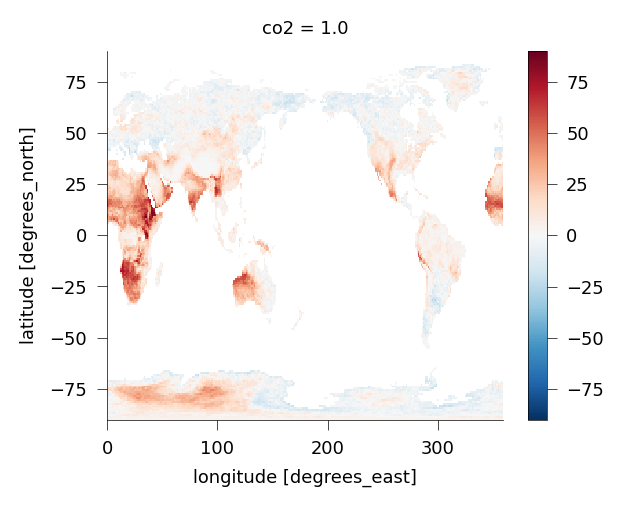

In [6]:
co2_plot_ind = 0

fig, ax = plt.subplots(1, 1)
fig_resize(fig, width['one_col'])
var = [utils.get_valid_mask(ds.sel(p_ft=p_ft)).where(lsm).sum(dim='sample').isel(co2=co2_plot_ind) /
       (~np.isnan(ds.TREFHT)).where(lsm).sum(dim='sample').isel(co2=co2_plot_ind) * 100 for p_ft in ds.p_ft]
(var[0] - var[1]).where(lsm).plot(ax=ax)
update_fontsize(fig)
plt.show()

In [7]:
%%time
p_ft_use = 400 * 100
ds = ds.sel(p_ft=p_ft_use)
ds['p_lnb_approx'] = get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm).isel(
    lev=ds.lnb_ind)
ds['lapse_Dz'] = ds.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.mod_parcel1_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']
lat_weights = utils.lat_weights.reindex_like(ds.lat)
temp_surf_lcl_calc = ds.temp_surf_lcl_calc
p_ft = float(ds.p_ft)

# Get rid of variables no longer need. Must remove those without lon, lat, sample in dimensions for fold_coarsen to work
drop_vars = ['hyam', 'hybm', 'lnb_ind', 'LANDFRAC', 'const1_lapse', 'mod_parcel1_lapse']
ds = ds.drop_vars(drop_vars)

CPU times: user 391 ms, sys: 440 ms, total: 832 ms
Wall time: 856 ms


## Sanity check for convective definition
Below I compare % of days where convection scheme triggered (b) with % of days classified as convective in our regime.

Also, use to say only consider land as ocean no real convection outside tropics.

In [8]:
# Also avoid regions below freezing
ds['mask_conv'] = utils.get_valid_mask(ds) & (ds.TS > temp_kelvin_to_celsius)
ds['lsm'] = (ds.TREFHT > 0).isel(co2=0) & lsm  # so lsm has sample dimension required for coarsening
ds['lat_weights'] = lat_weights.where((ds.TREFHT > 0).isel(co2=0))

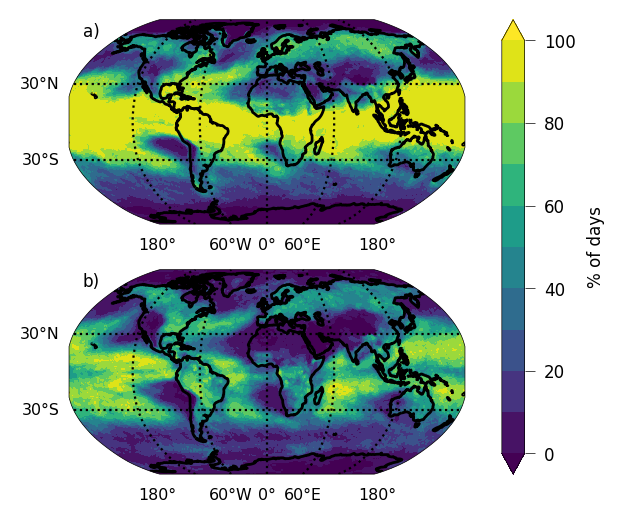

In [11]:
var = [(ds['mask_conv'].sum(dim='sample') / ds.sample.size*100).isel(co2=0),
       ((ds.FREQZM>0).sum(dim='sample') / ds.sample.size*100).isel(co2=0)]

gl_fontsize = 5.74
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0}, sharex=True, sharey=True)
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    gl = utils.initialize_ax_projection(ax_use, lat_min=-90, lat_max=90, grid_lat=[-30, 30], return_gl=True)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
contour_lev = np.linspace(0, 100, 11)
for i in range(len(var)):
    im = utils.plot_contour_projection(ax[i], var[i], levels=contour_lev, mask=None)
plt.colorbar(im, ax=ax.ravel(), label='% of days', pad=0.02)
# ax[0].set_title('Daily Average')
# ax[1].set_title('Daily Maximum')
label_subplots(fig, ax, box_alpha=0, pos_y=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

In [87]:
lat_min = -45
lat_max = 75
ds_coarse = fold_coarsen(ds.sel(lat=slice(lat_min, lat_max)), k_lat=4, k_lon=4)
ds_coarse['mask_conv'] = ds_coarse['mask_conv'] & ds_coarse['lsm']      # only include land from now on
ds_coarse.attrs['temp_surf_lcl_calc'] = temp_surf_lcl_calc
ds_coarse.attrs['p_ft'] = p_ft
mask_loc = (ds_coarse.mask_conv.sum(dim='sample') > 400).all(dim='co2')  # choose where > 500 days

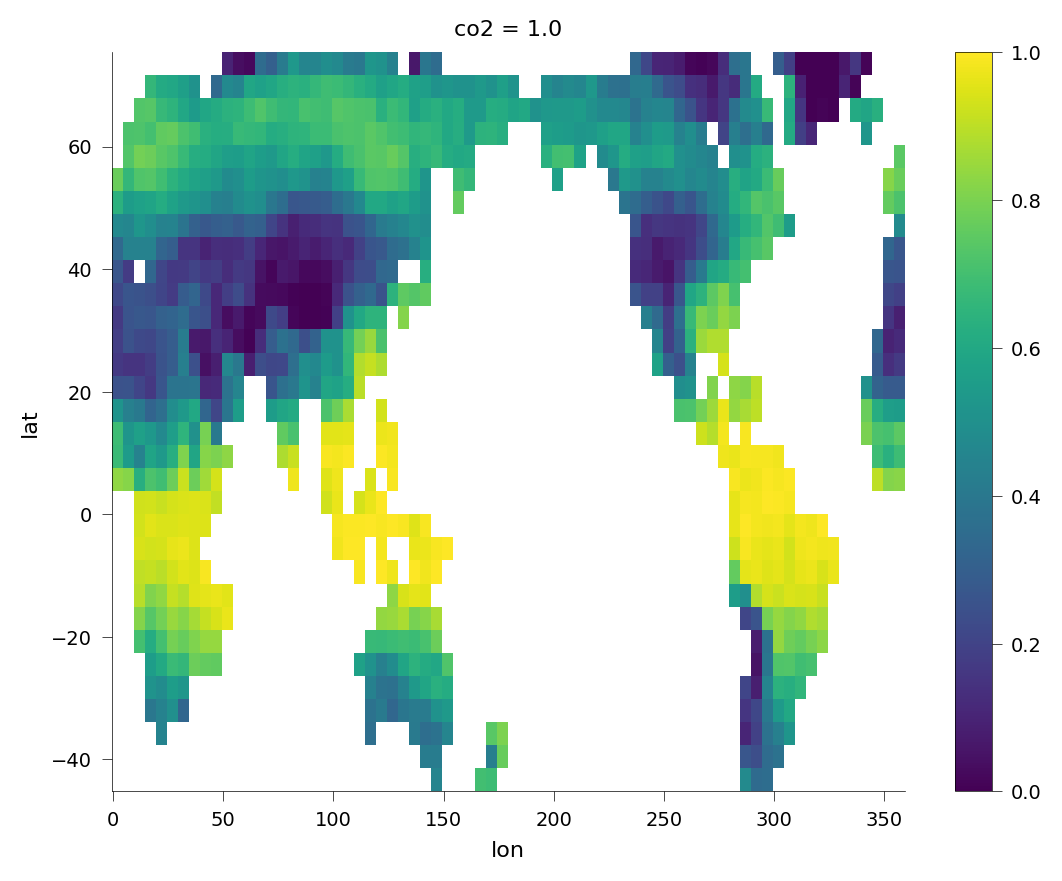

In [88]:
# % of land days convective
((ds_coarse.mask_conv).sum(dim='sample') / (ds_coarse.lsm).sum(dim='sample')).isel(co2=0).plot()
plt.show()

In [111]:
# Plots about role of ice
# (ds_coarse.SOLIN).where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()
# (ds_coarse.time_from_midday).where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()
# (ds_coarse.TS - ds_coarse.TREFHT < 0).where(ds_coarse.mask_conv).sum(dim='sample').diff(dim='co2').where(mask_loc).plot()

In [91]:
def get_midpoint(var, dim=None):
    return 0.5 * var.min(dim=dim) + 0.5 * var.max(dim=dim)

In [92]:
ds_lat = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample'])
ds_av_global = ds_coarse[['PREFHT', 'rh_REFHT', 'TREFHT', 'lapse_D', 'lapse_M', 'T_ft_env']].where(
    ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample', 'lat'])
ds_ref_global = ds_av_global.copy(deep=True)
# weights_use = ds_quant.mask_conv.sum(dim=['co2', 'sample'])
# ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim=['lon', 'sample']).diff(dim='co2').squeeze().plot()
# ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim=['sample']).diff(dim='co2').squeeze().weighted(weights_use).mean(dim='lon').plot()


In [93]:
# Set ref values - different from average, except for TREFHT change. Designed so the max positive and min anomaly are the same
# Also ref is forced to be a moist adiabat hence lapse values are zero
norm_by_av = False
if norm_by_av:
    ds_ref_global['TREFHT'].values[0] = get_midpoint(ds_lat.TREFHT.isel(co2=0))
    ds_ref_global['TREFHT'].values[1] = ds_ref_global['TREFHT'].isel(co2=0) + ds_av_global.TREFHT.diff(
        dim='co2').squeeze()
    ds_ref_global['rh_REFHT'].values[:] = get_midpoint(ds_lat.rh_REFHT.isel(co2=0))
    ds_ref_global['PREFHT'].values[:] = get_midpoint(ds_lat.PREFHT.isel(co2=0))
else:
    ds_ref_global['rh_REFHT'].values[1] = ds_ref_global['rh_REFHT'].values[0]
    ds_ref_global['PREFHT'].values[1] = ds_ref_global['PREFHT'].values[0]
ds_ref_global['lapse_D'].values[:] = 0  # so moist adiabat
ds_ref_global['lapse_M'].values[:] = 0
# Set reference FT temperature to that following a parcel profile
ds_ref_global['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref_global.rh_REFHT, ds_ref_global.PREFHT,
                                           p_ft, 0, 0, ds_ref_global['TREFHT'],
                                           input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                           kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

In [94]:
# ds_sf_lat = utils.apply_scale_factor_theory(ds_lat, ds_av_global, p_ft, temp_surf_lcl_calc, False, quant_dim='lat', numerical=True)
ds_sf_lat = utils.apply_scale_factor_theory(ds_lat, ds_ref_global, p_ft, temp_surf_lcl_calc, False, quant_dim='lat',
                                            numerical=False)
if norm_by_av:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av = utils.apply_scale_factor_theory(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global, p_ft,
                                               temp_surf_lcl_calc, False,
                                               quant_dim='newdim', numerical=False)
    for key in ds_sf_lat:
        ds_sf_lat[key] = ds_sf_lat[key] - ds_sf_av[key].isel(newdim=0) + 1

ds_sf_lat_num = utils.apply_scale_factor_theory(ds_lat, ds_ref_global, p_ft, temp_surf_lcl_calc, False, quant_dim='lat',
                                                numerical=True)

if norm_by_av:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_num = utils.apply_scale_factor_theory(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global, p_ft,
                                                   temp_surf_lcl_calc, False,
                                                   quant_dim='newdim', numerical=True)
    for key in ds_sf_lat_num:
        ds_sf_lat_num[key] = ds_sf_lat_num[key] - ds_sf_av_num[key].isel(newdim=0) + 1

In [95]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_lat_num["nl_sum"] = ds_sf_lat_num['scale_factor_nl'] - ds_sf_lat_num['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf_lat:
    if 'scale_factor_sum' in key:
        continue
    ds_sf_lat_num[key] = ds_sf_lat_num[key] - ds_sf_lat[key] + 1

In [103]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", utils.labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", utils.labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", utils.labels_cont['lapse_D_change']),
    "lapse_M_change": ("C1", "-", utils.labels_cont['lapse_M_change']),
    "sCAPE_change": ("C1", ":", utils.labels_cont['sCAPE_change']),
    "p_surf_change": ("C0", ":", utils.labels_cont['p_surf_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", utils.labels_cont['temp_surf_anom']),
    "rh_anom": ("C4", "-", utils.labels_cont['rh_anom']),
    "p_surf_anom": ("C4", ":", utils.labels_cont['p_surf_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory'),

    # non-linear
    "nl_temp_surf_anom_rh_change": ('C3', '-', '$\Delta T_s \delta r_s$'),
    "nl_rh_change_lapse_D_anom": ('C0', '-', '$\Delta \eta_D \delta r_s$'),
    "nl_temp_surf_anom_lapse_M_change": ('C1', '-', '$\Delta T_s \delta \eta_M$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$'),
    "nl_temp_ft_change_rh_anom": ('C2', '-', '$\Delta T_s \delta T_{FT}$'),
    "nl_temp_ft_change_p_surf_anom": ('C2', '-', '$\Delta p_s \delta T_{FT}$'),
    "nl_temp_surf_anom_rh_anom": ('C4', '-', '$\Delta T_s \Delta r_s$'),
    "nl_temp_surf_anom_p_surf_anom": ('C4', ':', '$\Delta T_s \Delta p_s$'),
    "nl_rh_change_rh_anom": ('C0', '-', '$\Delta r_s \delta r_s$'),
    "nl_temp_surf_anom_lapse_D_anom": ('C8', '-', '$\Delta T_s \Delta \eta_D$'),
    "nl_rh_anom_lapse_M_change": ('C1', '-', '$\Delta r_s \delta \eta_M$'),
    "nl_residual": ('C6', '-', 'Sum $\geq 3$ mechanisms')
}

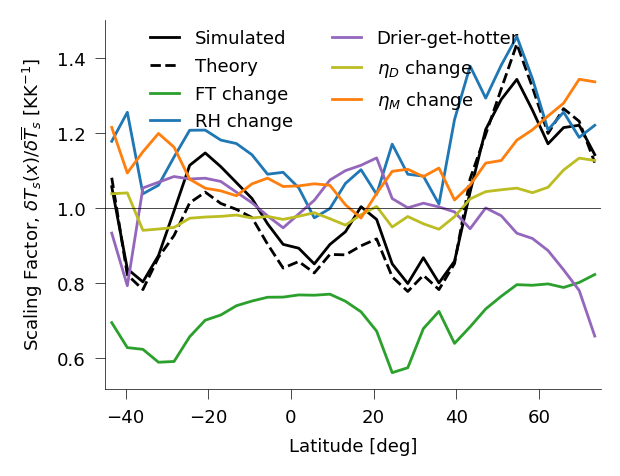

In [107]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)
fig_resize(fig, width['one_col'])
for key in ['', '_sum']:
    ax.plot(ds_sf_lat.lat, ds_sf_lat[f"scale_factor{key}"],
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label=style_map[f"scale_factor{key}"][2])
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf_lat:
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        continue
    if np.nanmax(np.abs(ds_sf_lat[key] - 1)) < 0.05:
        continue
    ax.plot(ds_sf_lat.lat, ds_sf_lat[key], label=style_map[key][2].replace('Hot', 'Cold'),
            color=style_map[key][0],
            linestyle=style_map[key][1])

update_linewidth(fig)
ax.legend(ncol=2, handlelength=leg_handlelength, bbox_to_anchor=(0.87, 1.02), loc='upper right')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel(utils.sf_label)
update_fontsize(fig, 6.5)
ax.set_xlim(lat_min, lat_max)
# ax.set_ylim(0.72, 1.45)
# ax[0].legend(ncol=2)
plt.show()
# savefig(fig)

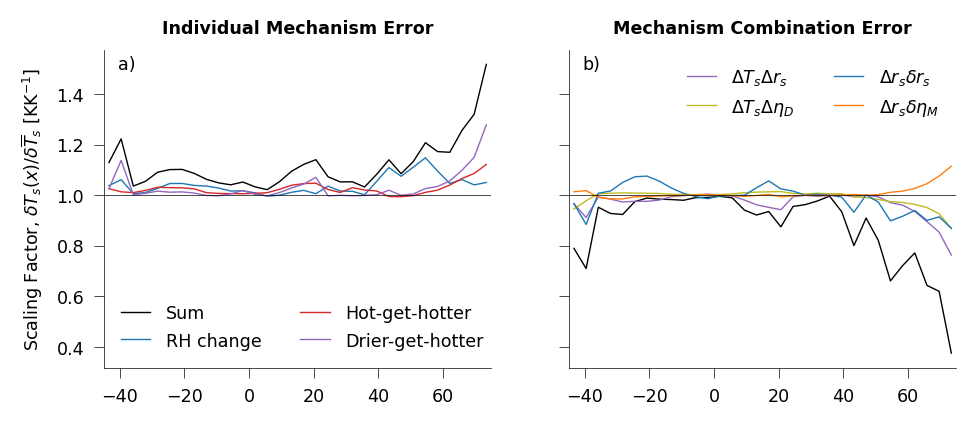

In [109]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_lat_num.lat,
           (ds_sf_lat_num['scale_factor_linear'] - ds_sf_lat['scale_factor_sum'] + 1),
           color='k', label='Sum')
ax[1].plot(ds_sf_lat_num.lat, ds_sf_lat_num['nl_sum'],
           color='k', linestyle='-')

# Plot individual mechanism error
for key in ds_sf_lat:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) < 0.05:
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) > 0.05:
        ax[0].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_lat_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('residual' in key):
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) > 0.11:
        # ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key)
        ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
# key = 'nl_error_av_change'
# ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key, color='C6')
# key = 'nl_residual'
# ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key, color='C6')
# update_linewidth(fig)

# Reorder ax1 legend
# handles, labels = ax[1].get_legend_handles_labels()
# order = [0, 1, 2, 4, 3, 5]  # desired new order by index
# ax[1].legend([handles[i] for i in order],
#              [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)
ax[0].legend(ncol=2, handlelength=leg_handlelength)
ax[1].legend(ncol=2, handlelength=leg_handlelength)
# ax[0].set_xlim(0, 100)
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
# ax[0].set_xlabel(percentile_label)
# ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel(utils.sf_label)
update_fontsize(fig)
# ax[0].set_ylim(0.97, 1.03)
ax[0].set_xlim(lat_min, lat_max)
plt.show()
# savefig(fig)

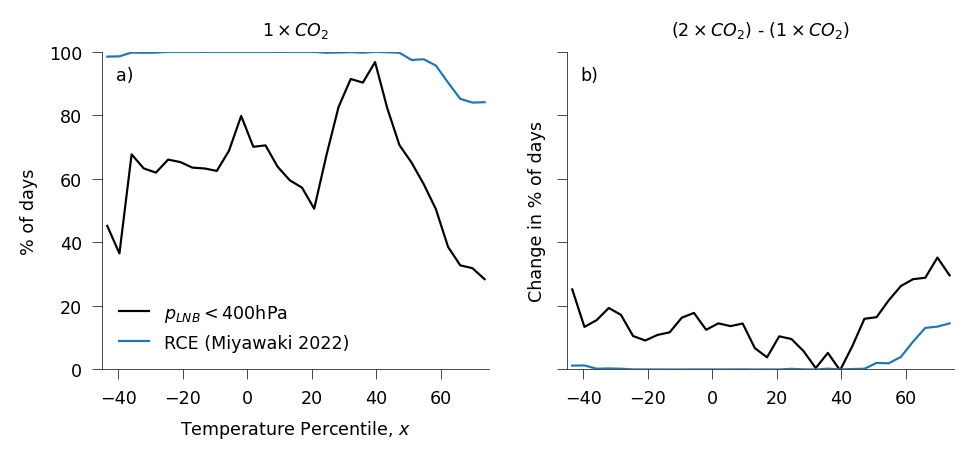

In [120]:
# Probably can just show a spatial version of the right plot
lapse_miy2022_M_thresh = 13  # 13% threshold value for RCE comes from paper
lnb_buoyancy_method = 'lcl'     # think lcl is better - better estimate of height convection can possibly reach
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
n_sample = (ds_coarse.mask_conv & mask_loc).sum(dim=['sample', 'lon'])       # total number of convective days at each location
var = (ds_coarse.p_lnb_approx.where(ds_coarse.mask_conv & mask_loc) < p_ft).sum(dim=['sample', 'lon']) / n_sample * 100
var = var.sel(parcel_type=lnb_buoyancy_method)
ax[0].plot(ds_lat.lat, var.isel(co2=0), color=f"k", label='$p_{LNB} < ' + f'{p_ft / 100:.0f}$hPa')
ax[1].plot(ds_lat.lat, var.diff(dim='co2').squeeze(), color=f"k")

var = (ds_coarse.lapse_miy2022_M.where(ds_coarse.mask_conv & mask_loc) < lapse_miy2022_M_thresh).sum(dim=['sample', 'lon']) / n_sample * 100
ax[0].plot(ds_lat.lat, var.isel(co2=0), color=f"C0",
           label='RCE (Miyawaki 2022)')
ax[1].plot(ds_lat.lat, var.diff(dim='co2').squeeze(), color=f"C0")

update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(lat_min, lat_max)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days')
ax[0].set_xlabel(utils.percentile_label)
ax[0].set_title(utils.co2_labels[0])
ax[1].set_title(f'({utils.co2_labels[1]}) - ({utils.co2_labels[0]})')
label_subplots(fig, ax, box_alpha=0)
update_fontsize(fig)
plt.show()
# savefig(fig)

In [121]:
ds_spatial = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim='sample')
ds_av_lat = ds_lat[['PREFHT', 'rh_REFHT', 'TREFHT', 'lapse_D', 'lapse_M', 'T_ft_env']]
ds_ref_lat = ds_av_lat.copy(deep=True)
norm_by_av_spatial = True
if norm_by_av_spatial:
    ds_ref_lat['TREFHT'].values[0] = get_midpoint(ds_spatial.TREFHT.isel(co2=0), dim='lon')
    ds_ref_lat['TREFHT'].values[1] = ds_ref_lat['TREFHT'].isel(co2=0) + ds_av_lat.TREFHT.diff(dim='co2').squeeze()
    ds_ref_lat['rh_REFHT'].values[:] = get_midpoint(ds_spatial.rh_REFHT.isel(co2=0), dim='lon')
    ds_ref_lat['PREFHT'].values[:] = get_midpoint(ds_spatial.PREFHT.isel(co2=0), dim='lon')
else:
    ds_ref_lat['rh_REFHT'].values[1] = ds_ref_lat['rh_REFHT'].values[0]
    ds_ref_lat['PREFHT'].values[1] = ds_ref_lat['PREFHT'].values[0]
ds_ref_lat['lapse_D'].values[:] = 0  # so moist adiabat
ds_ref_lat['lapse_M'].values[:] = 0
# Set reference FT temperature to that following a parcel profile
ds_ref_lat['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref_lat.rh_REFHT, ds_ref_lat.PREFHT,
                                        p_ft, 0, 0, ds_ref_lat['TREFHT'],
                                        input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                        kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

In [ ]:
# Takes 10 mins for 4 x 4 grid
ds_sf_spatial = []
ds_sf_spatial_num = []
for i in tqdm(range(ds_spatial.lat.size)):
    ds_sf_spatial.append(
        utils.apply_scale_factor_theory(ds_spatial.isel(lat=i), ds_ref_lat.isel(lat=i), p_ft, temp_surf_lcl_calc,
                                        False, quant_dim='lon', numerical=False))
    ds_sf_spatial_num.append(
        utils.apply_scale_factor_theory(ds_spatial.isel(lat=i), ds_ref_lat.isel(lat=i), p_ft, temp_surf_lcl_calc,
                                        False, quant_dim='lon', numerical=True))
ds_sf_spatial = xr.concat(ds_sf_spatial, dim=ds_spatial.lat)
ds_sf_spatial_num = xr.concat(ds_sf_spatial_num, dim=ds_spatial.lat)
# ds_spatial = xr.
if norm_by_av_spatial:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_spatial = []
    ds_sf_av_spatial_num = []
    for i in range(ds_spatial.lat.size):
        ds_sf_av_spatial.append(
            utils.apply_scale_factor_theory(ds_av_lat.isel(lat=i).expand_dims({"newdim": [0]}), ds_ref_lat.isel(lat=i),
                                            p_ft,
                                            temp_surf_lcl_calc, False,
                                            quant_dim='newdim', numerical=False))
        ds_sf_av_spatial_num.append(
            utils.apply_scale_factor_theory(ds_av_lat.isel(lat=i).expand_dims({"newdim": [0]}), ds_ref_lat.isel(lat=i),
                                            p_ft,
                                            temp_surf_lcl_calc, False,
                                            quant_dim='newdim', numerical=True))
    ds_sf_av_spatial = xr.concat(ds_sf_av_spatial, dim=ds_spatial.lat)
    ds_sf_av_spatial_num = xr.concat(ds_sf_av_spatial_num, dim=ds_spatial.lat)
    for key in ds_sf_spatial:
        ds_sf_spatial[key] = ds_sf_spatial[key] - ds_sf_av_spatial[key].isel(newdim=0) + 1
    for key in ds_sf_spatial_num:
        ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - ds_sf_av_spatial_num[key].isel(newdim=0) + 1

  0%|          | 0/32 [00:00<?, ?it/s]

In [54]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_spatial_num["nl_sum"] = ds_sf_spatial_num['scale_factor_nl'] - ds_sf_spatial_num['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf_spatial:
    if 'scale_factor_sum' in key:
        continue
    ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - ds_sf_spatial[key] + 1

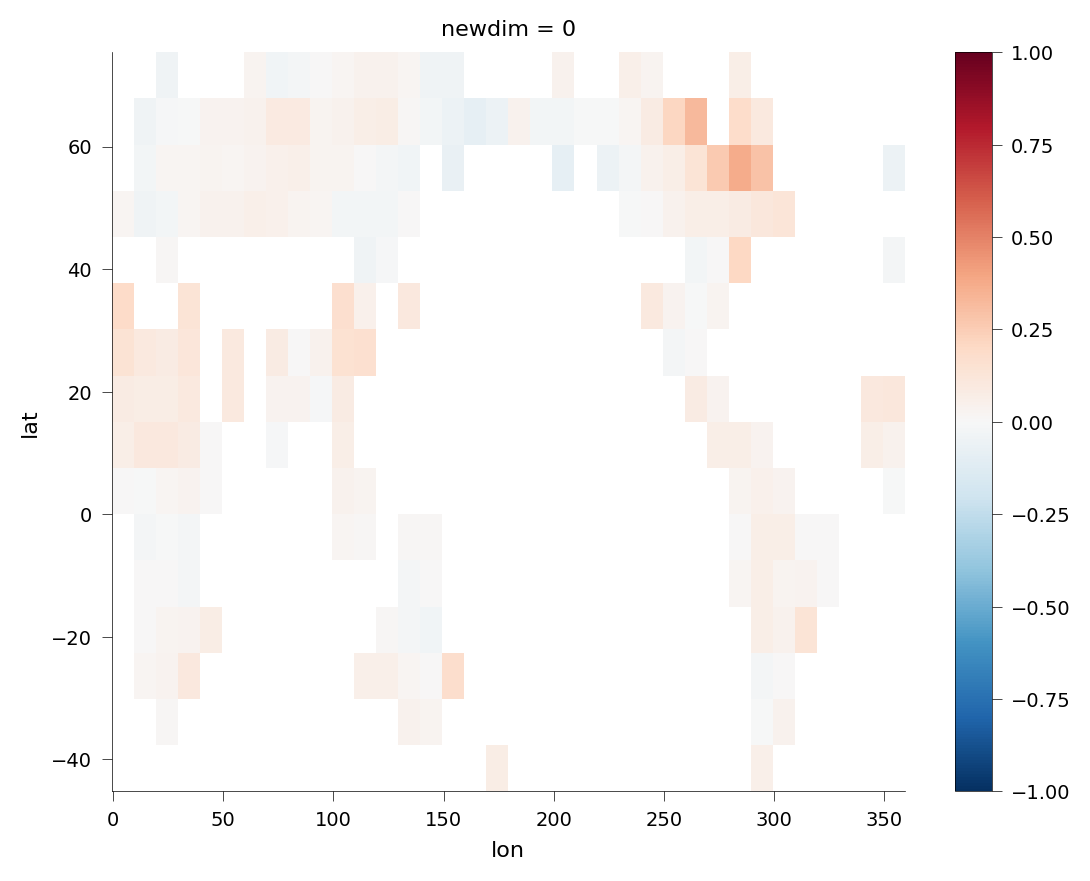

In [55]:
(ds_sf_spatial_num['scale_factor_linear'] - ds_sf_spatial['scale_factor_sum']).plot(vmax=1)

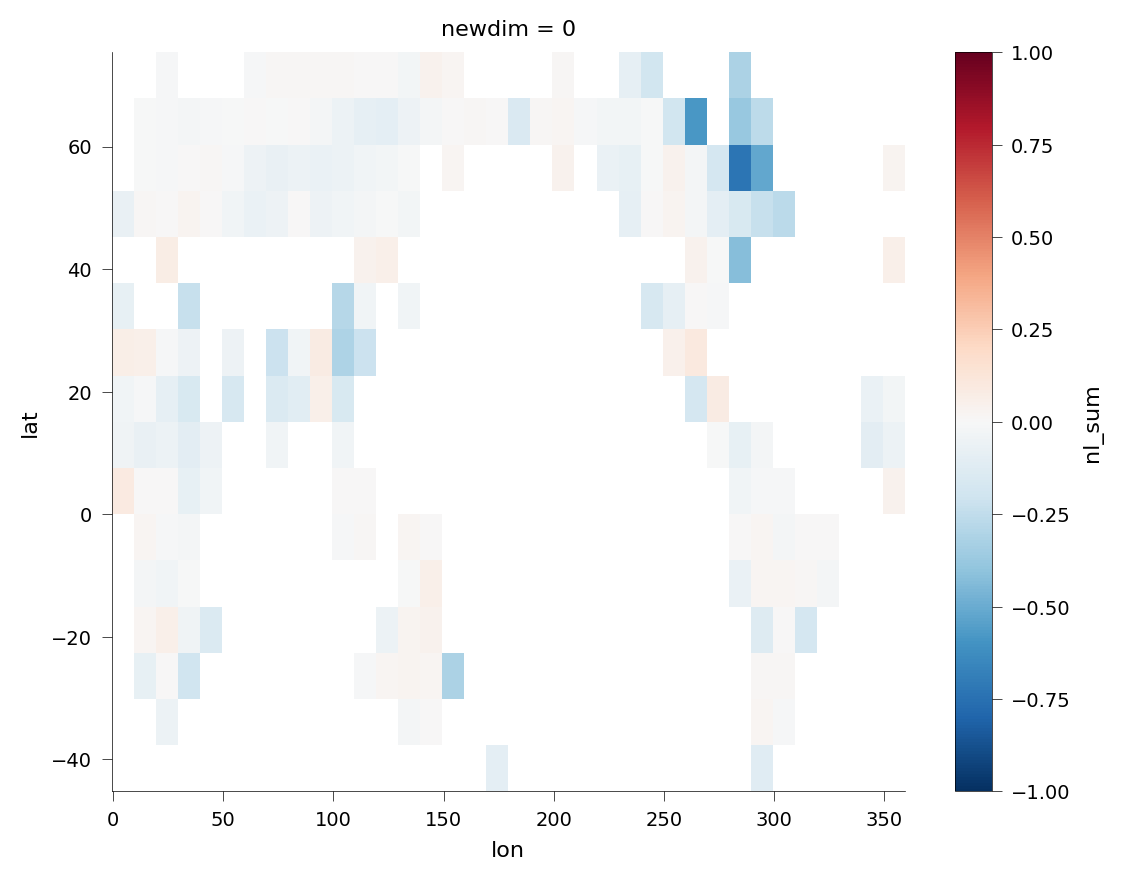

In [56]:
(ds_sf_spatial_num["nl_sum"]-1).plot(vmax=1)

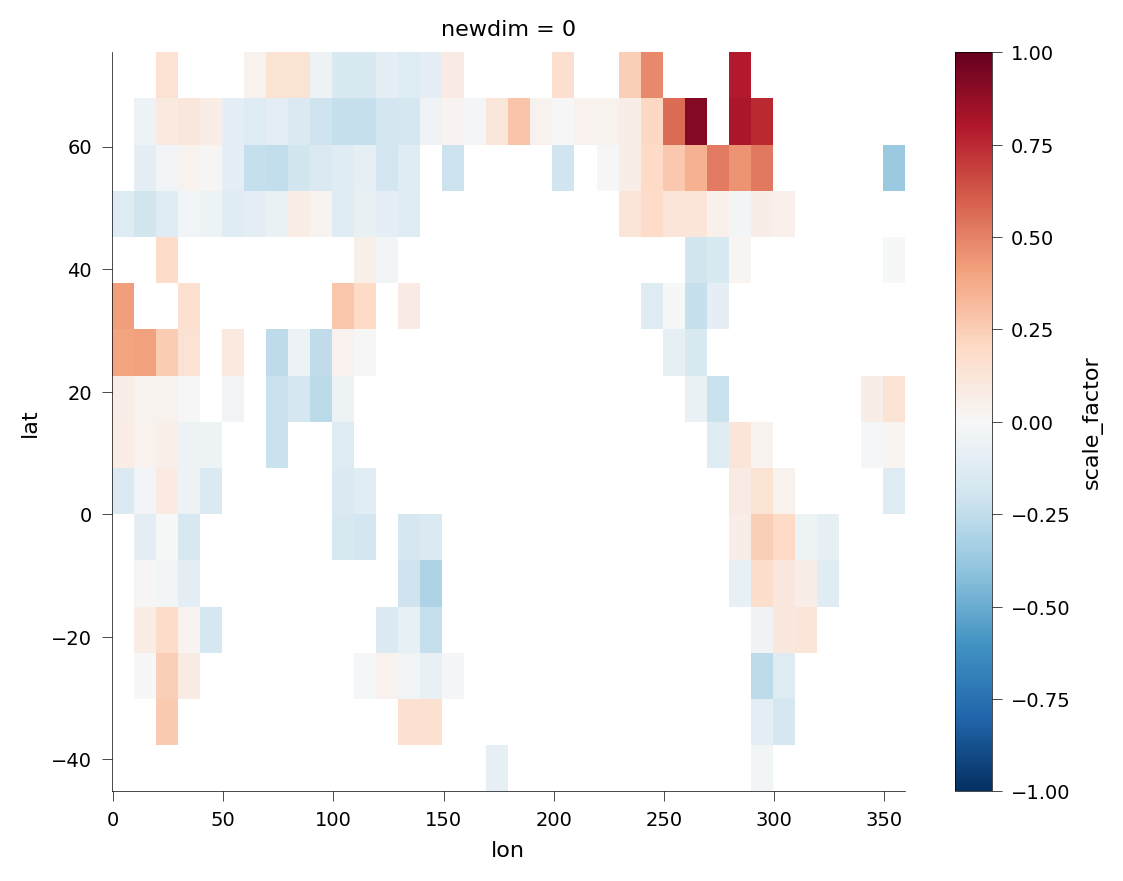

In [57]:
(ds_sf_spatial.scale_factor - 1).plot(vmax=1)

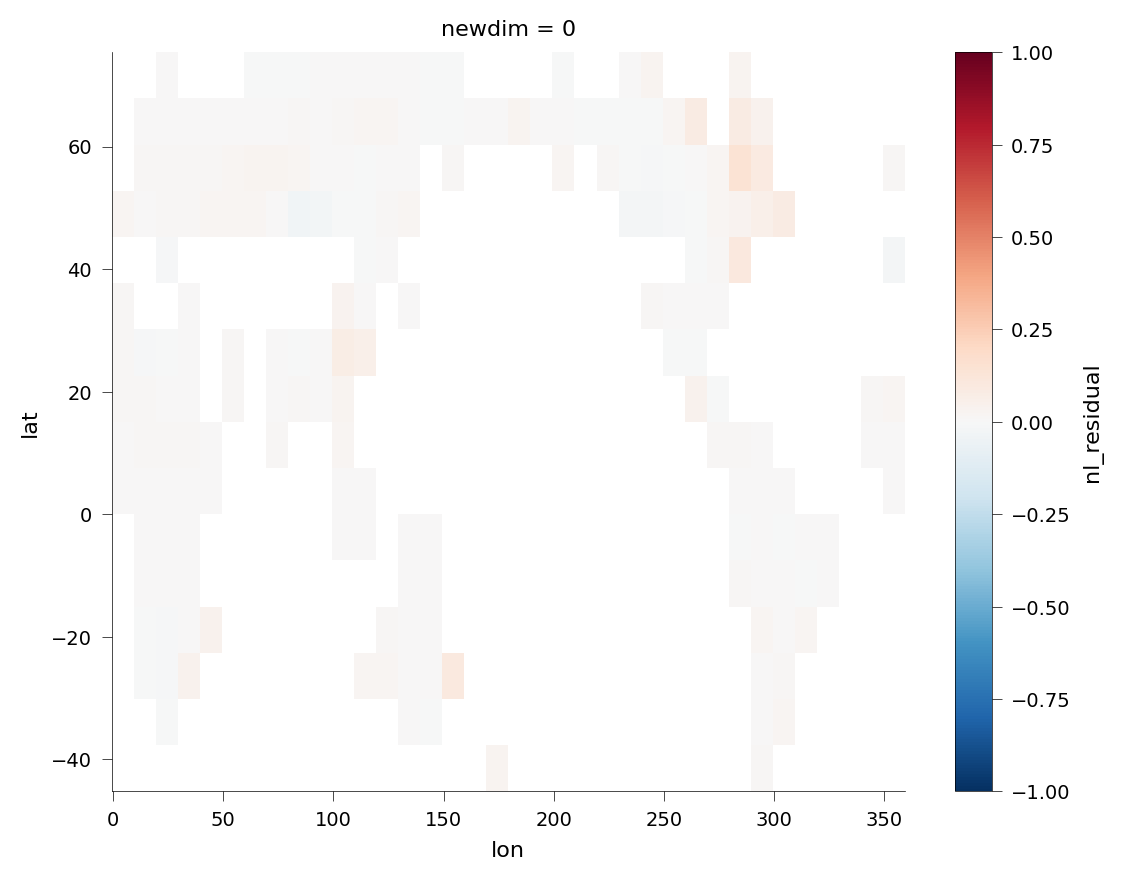

In [58]:
(ds_sf_spatial_num.nl_residual - 1).plot(vmax=1)

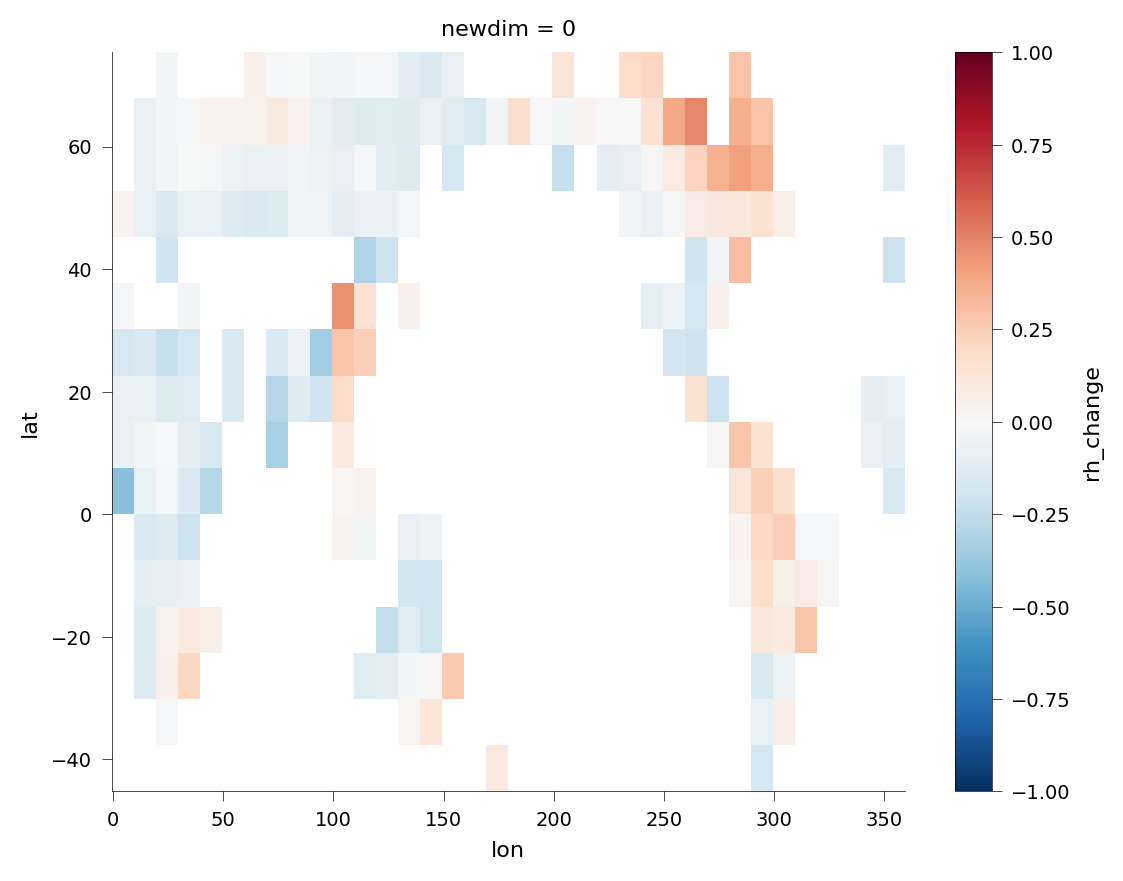

In [59]:
(ds_sf_spatial.rh_change - 1).plot(vmax=1)

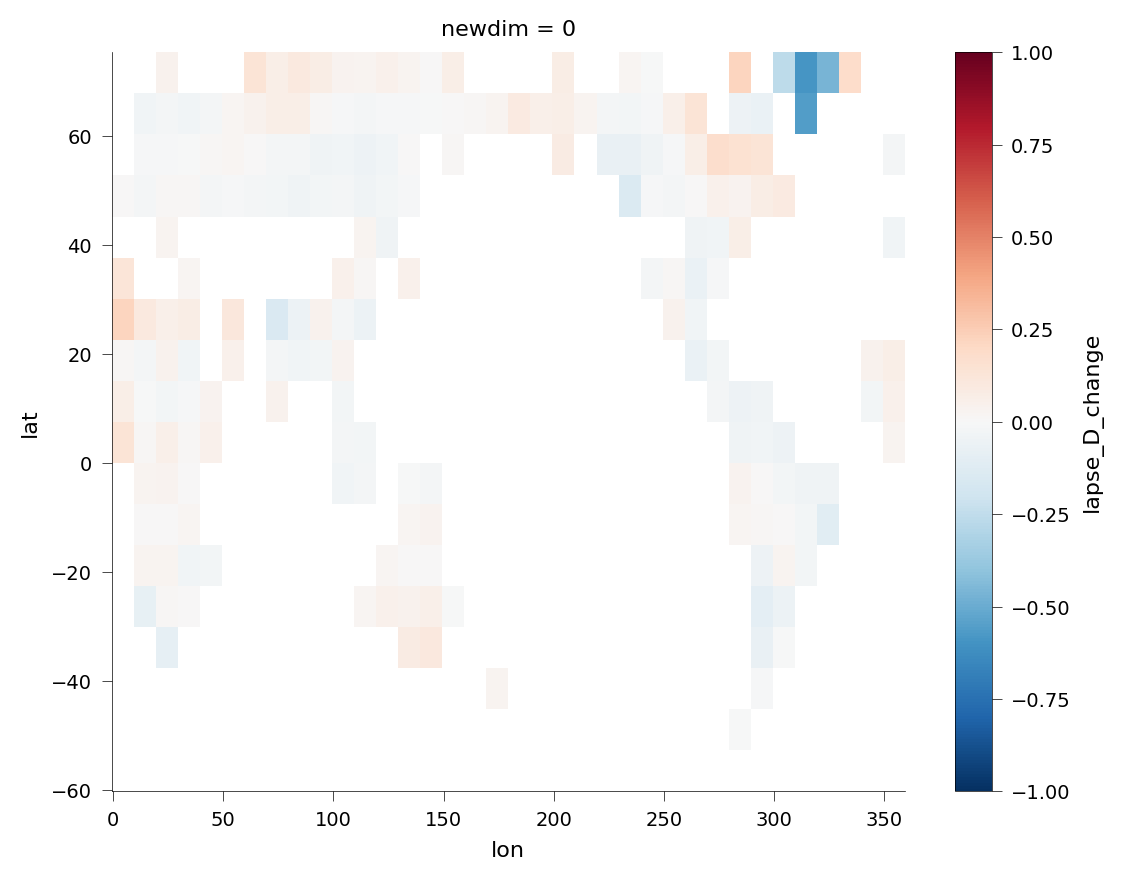

In [364]:
(ds_sf_spatial.lapse_D_change - 1).plot(vmax=1)

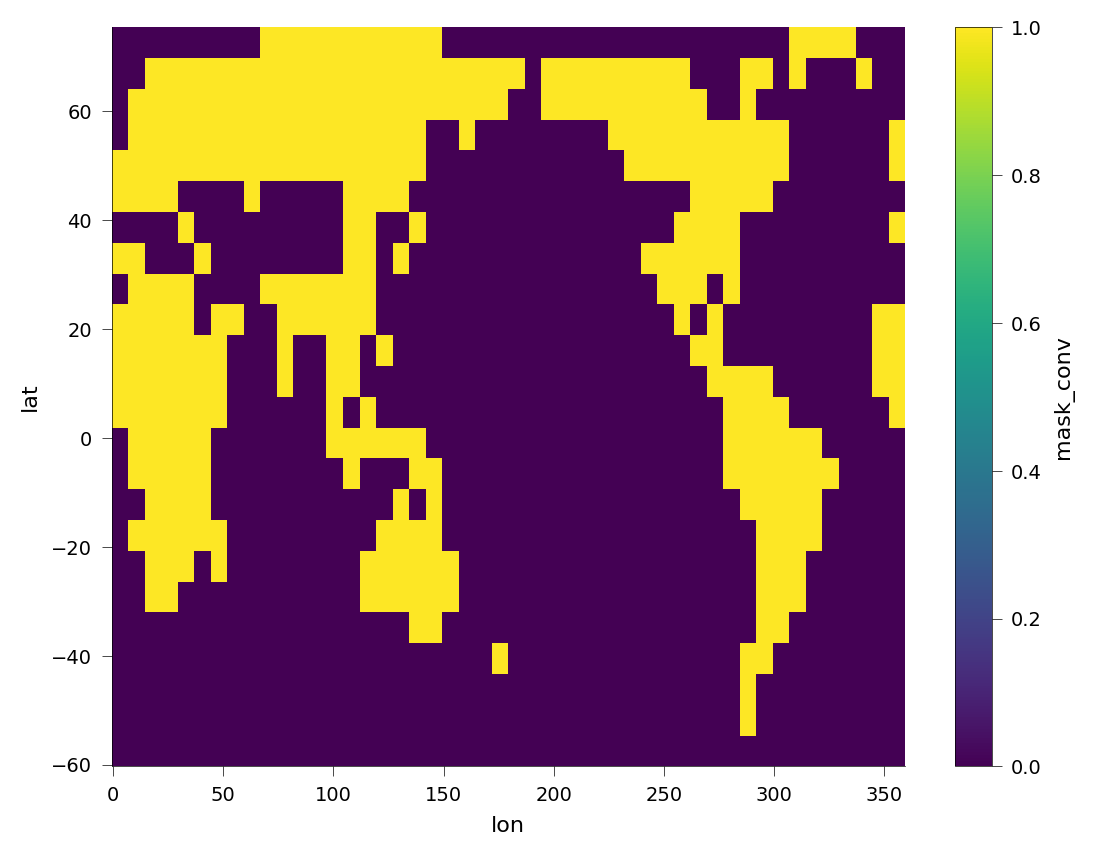

In [120]:
mask_loc.plot()

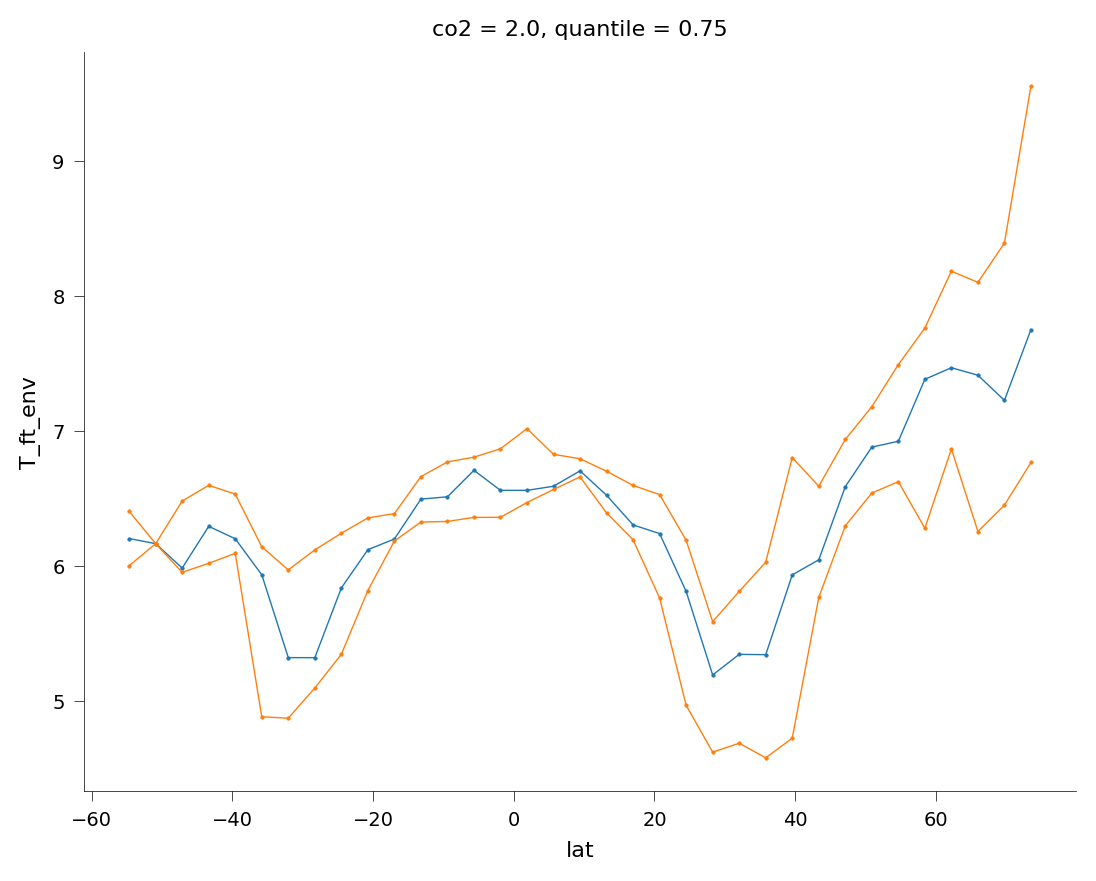

In [82]:
ds2 = fold_coarsen(ds, 4, 6)
# ds2.where(ds2.mask_conv).TREFHT.diff(dim='co2').mean(dim=['lon', 'sample']).plot(marker='.')
var = 'T_ft_env'
ds2.where(ds2.mask_conv)[var].diff(dim='co2').median(dim='sample').median(dim='lon').plot(marker='.')
ds2.where(ds2.mask_conv)[var].diff(dim='co2').median(dim='sample').quantile(0.25, dim='lon').plot(marker='.', c='C1')
ds2.where(ds2.mask_conv)[var].diff(dim='co2').median(dim='sample').quantile(0.75, dim='lon').plot(marker='.', c='C1')

In [84]:
# ds2 = fold_coarsen(ds, 3, 6)
ds2.attrs['temp_surf_lcl_calc'] = temp_surf_lcl_calc
ds2.attrs['p_ft'] = p_ft
mask_loc = (ds2.mask_conv.sum(dim='sample') / ds2.sample.size > 0.25).all(dim='co2')

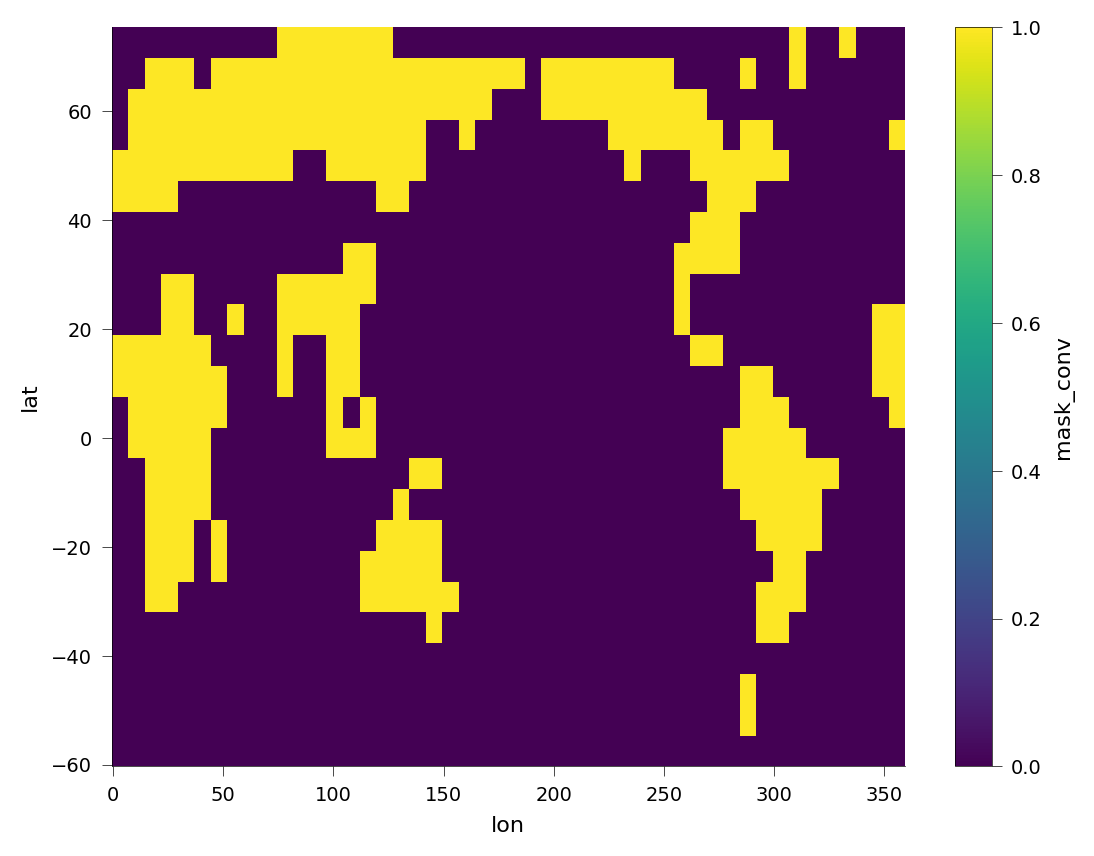

In [76]:
mask_loc.plot()

In [153]:
def get_var_av(var, n_lat_av=30, mask=None, av_dim=None):
    """Compute latitude-smoothed mean of a variable, ensuring no NaN latitudes.

    Args:
        var (xr.DataArray): Variable with dimensions ('lat', 'lon', 'sample', ...).
        n_lat_av (int, optional): Number of latitude points for rolling mean. Defaults to 30.
        mask (xr.DataArray, optional): Land-sea mask (True where valid). Defaults to None.

    Returns:
        xr.DataArray: Latitude-smoothed mean with all latitudes filled.
    """
    n_pad = n_lat_av // 2  # half-window size

    # Apply mask if provided
    if mask is not None:
        var = var.where(mask)

    # Take median over non-lat dims
    if av_dim is None:
        av_dim = [d for d in var.dims if d not in ['lat']]
    var_latmean = var.median(dim=av_dim)

    # Fill NaNs along latitude by nearest interpolation
    var_filled = var_latmean.interpolate_na(dim="lat", method="nearest", fill_value="extrapolate")

    # Pad with edge values to avoid NaNs at the ends
    var_padded = var_filled.pad(lat=(n_pad, n_pad), mode="edge")

    # Apply rolling mean and trim padding
    var_av = var_padded.rolling(lat=n_lat_av, center=True).mean().isel(lat=slice(n_pad, -n_pad))

    return var_av

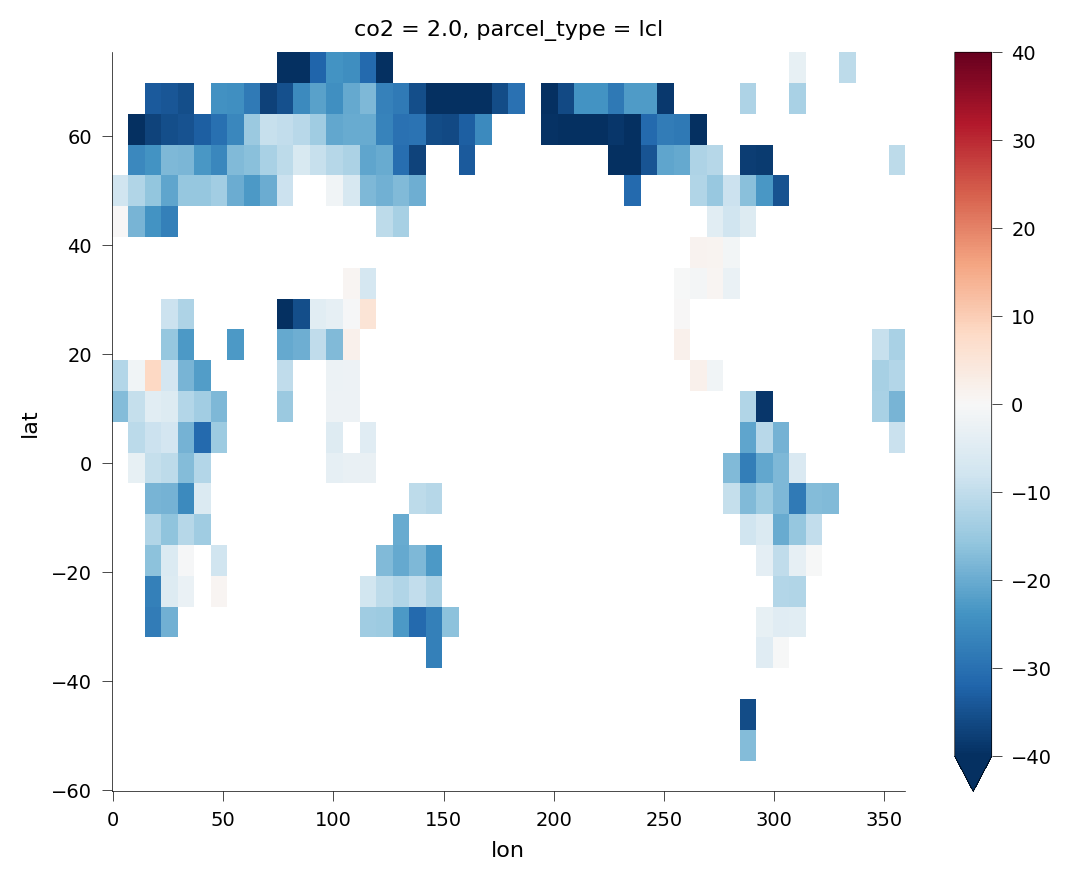

In [66]:
((ds2.p_lnb_approx.isel(parcel_type=1) > p_ft).where(ds2.mask_conv).sum(dim='sample') / ds2.mask_conv.sum(
    dim='sample') * 100).where(mask_loc).diff(dim='co2').squeeze().plot(vmax=40)

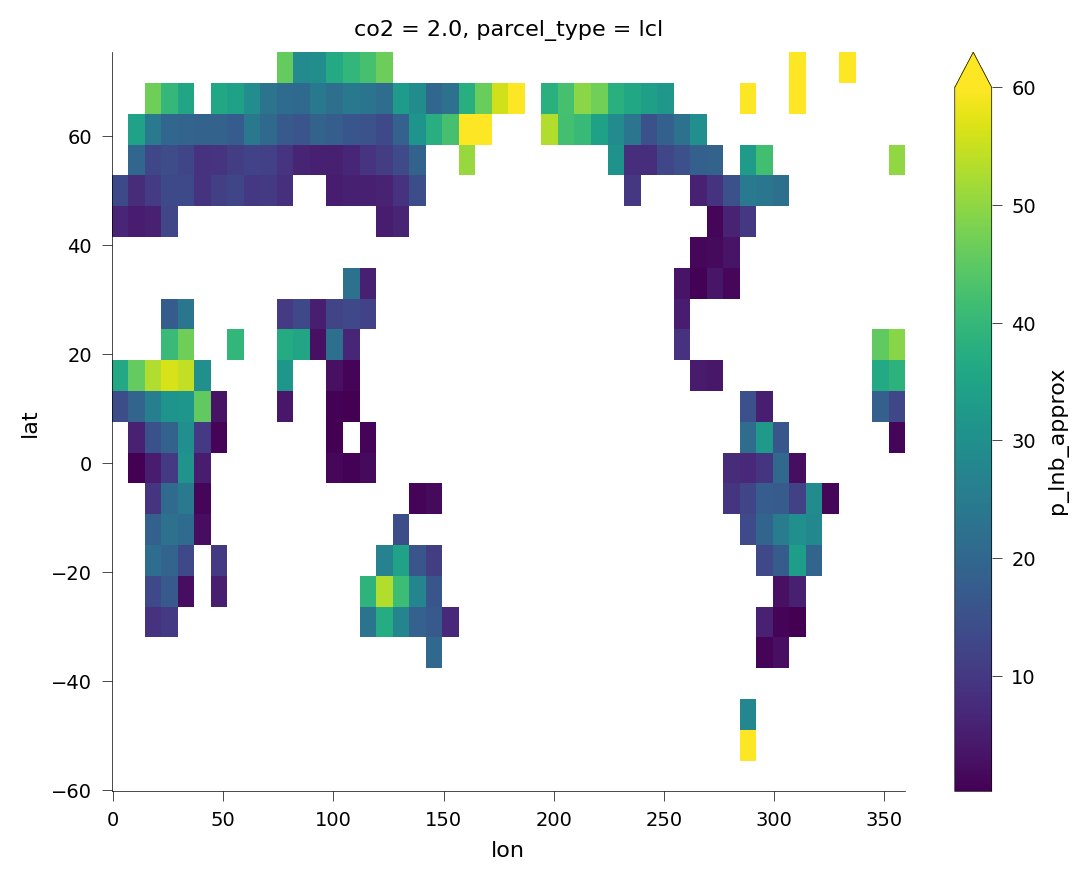

In [78]:
((ds2.p_lnb_approx.isel(parcel_type=1) > p_ft).sum(dim='sample') / ds2.sample.size * 100).where(mask_loc).isel(
    co2=1).plot(vmax=60)

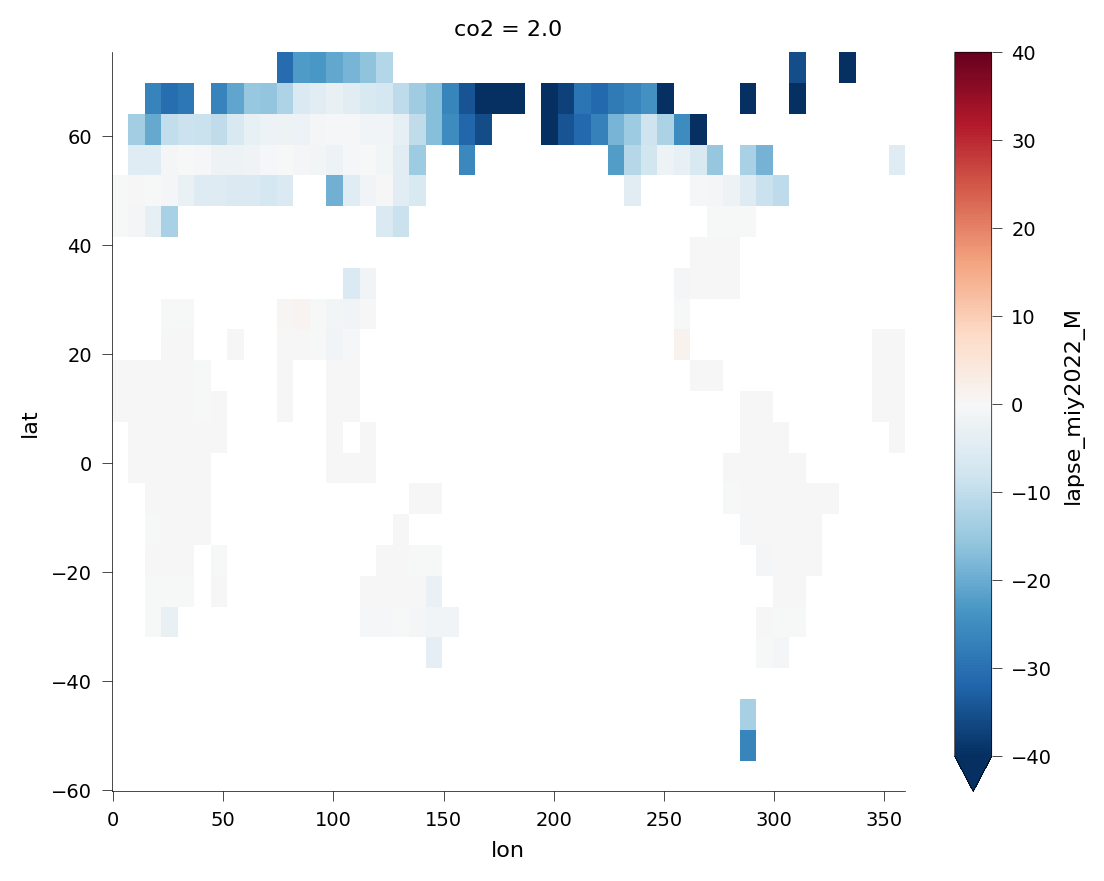

In [77]:
((ds2.lapse_miy2022_M > 13).sum(dim='sample') / ds2.sample.size * 100).where(mask_loc).diff(dim='co2').squeeze().plot(
    vmax=40)

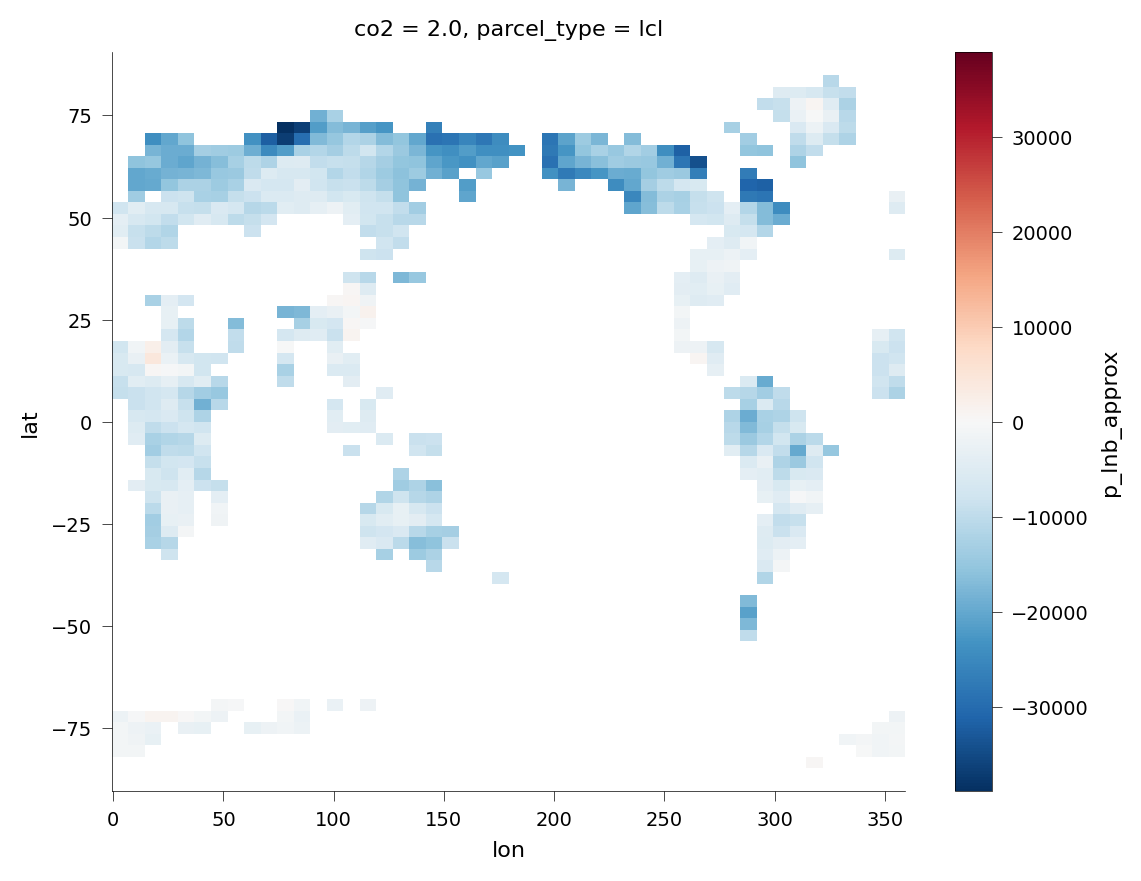

In [125]:
ds2.p_lnb_approx.isel(parcel_type=1).where(ds2.mask_conv).mean(dim='sample').diff(dim='co2').squeeze().where(
    mask_loc).plot()

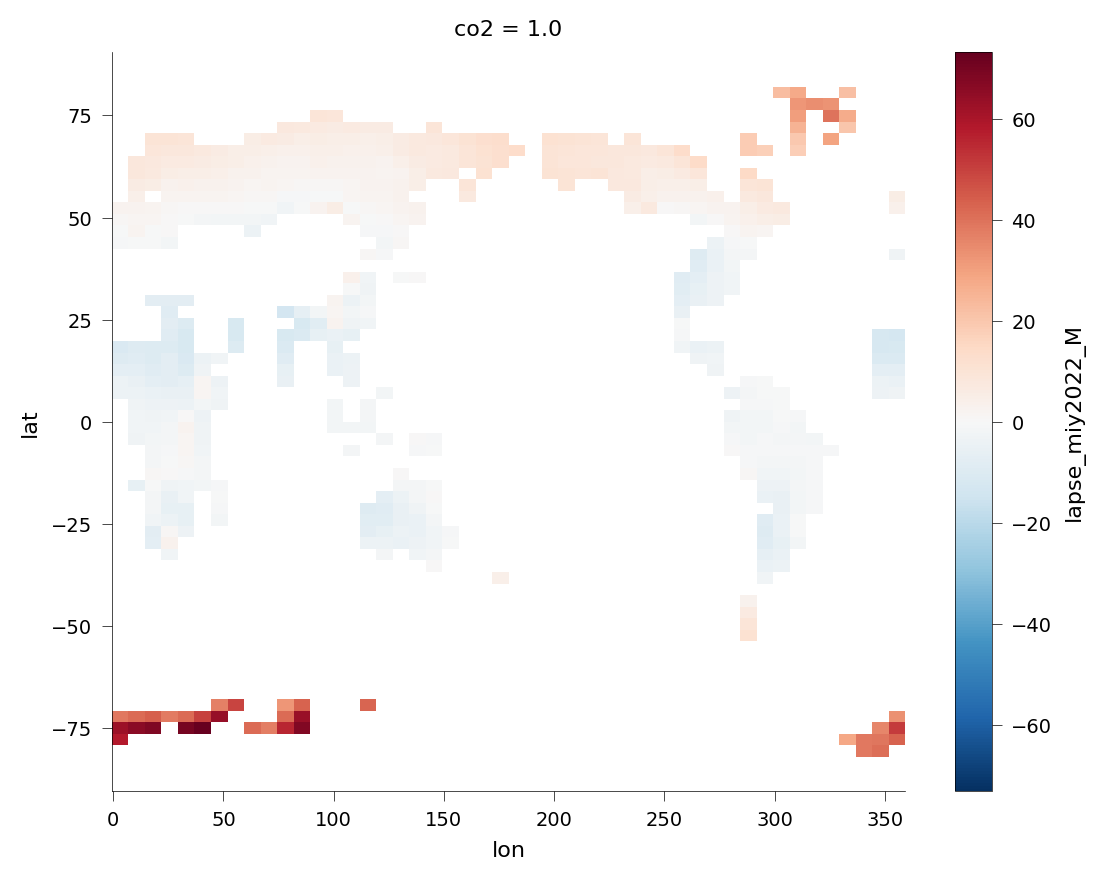

In [149]:
ds2.lapse_miy2022_M.where(ds2.mask_conv).mean(dim='sample').isel(co2=0).where(mask_loc).plot()

In [163]:
ds_ref = fold_coarsen(ds[['PREFHT', 'rh_REFHT', 'TREFHT', 'lapse_D', 'lapse_M', 'T_ft_env']], 8, 6)
# ds_ref = ds_ref.where(mask_loc).median(dim=['sample', 'lat', 'lon'])

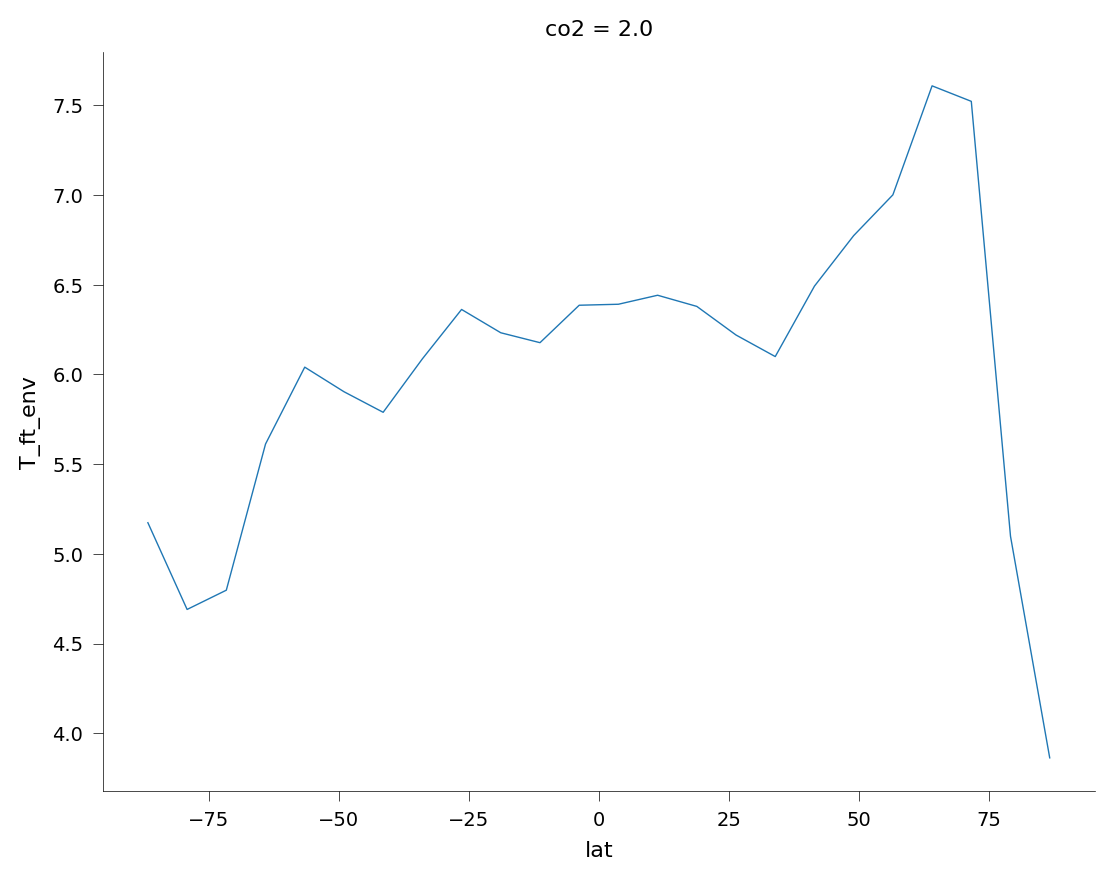

In [173]:
ds_ref.T_ft_env.mean(dim='lon').mean(dim='sample').diff(dim='co2').squeeze().plot()
# ds_ref.TREFHT.mean(dim='lon').mean(dim='sample').isel(co2=1).plot()

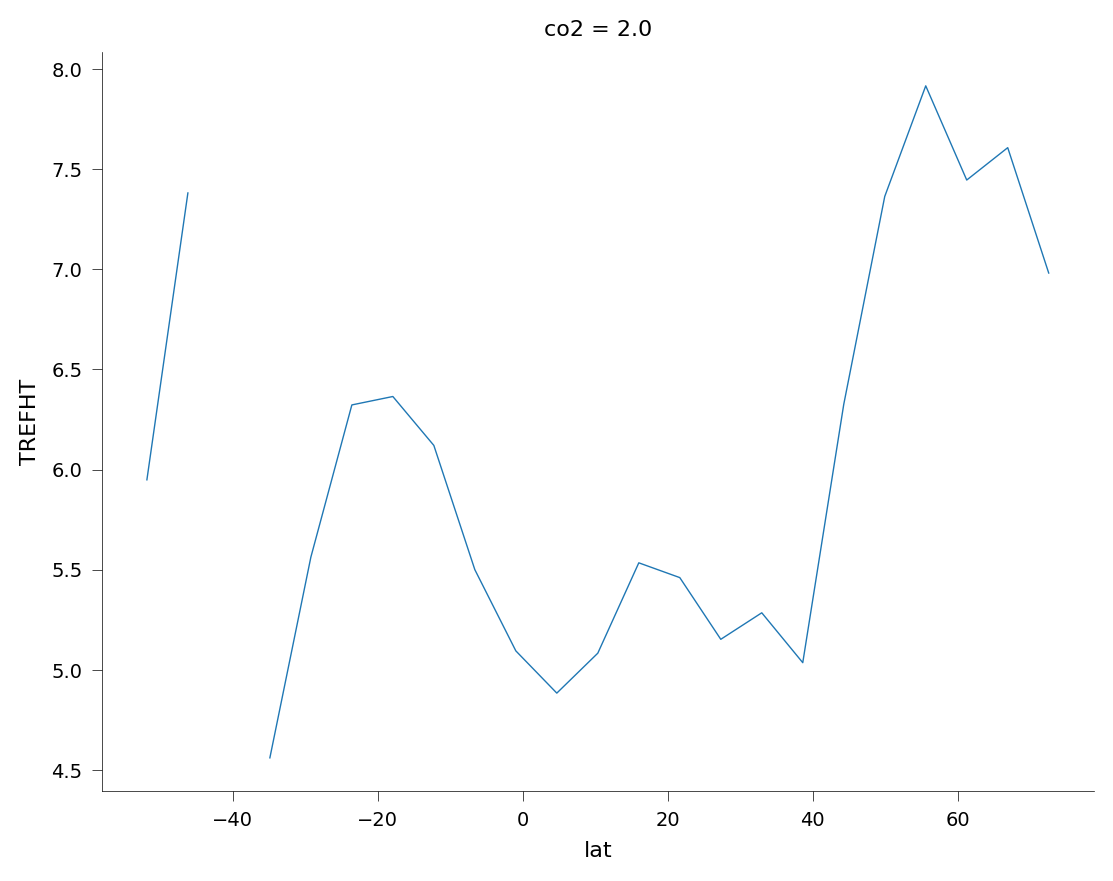

In [80]:
ds2.TREFHT.where(mask_loc).mean(dim=['lon', 'sample']).diff(dim='co2').squeeze().plot()

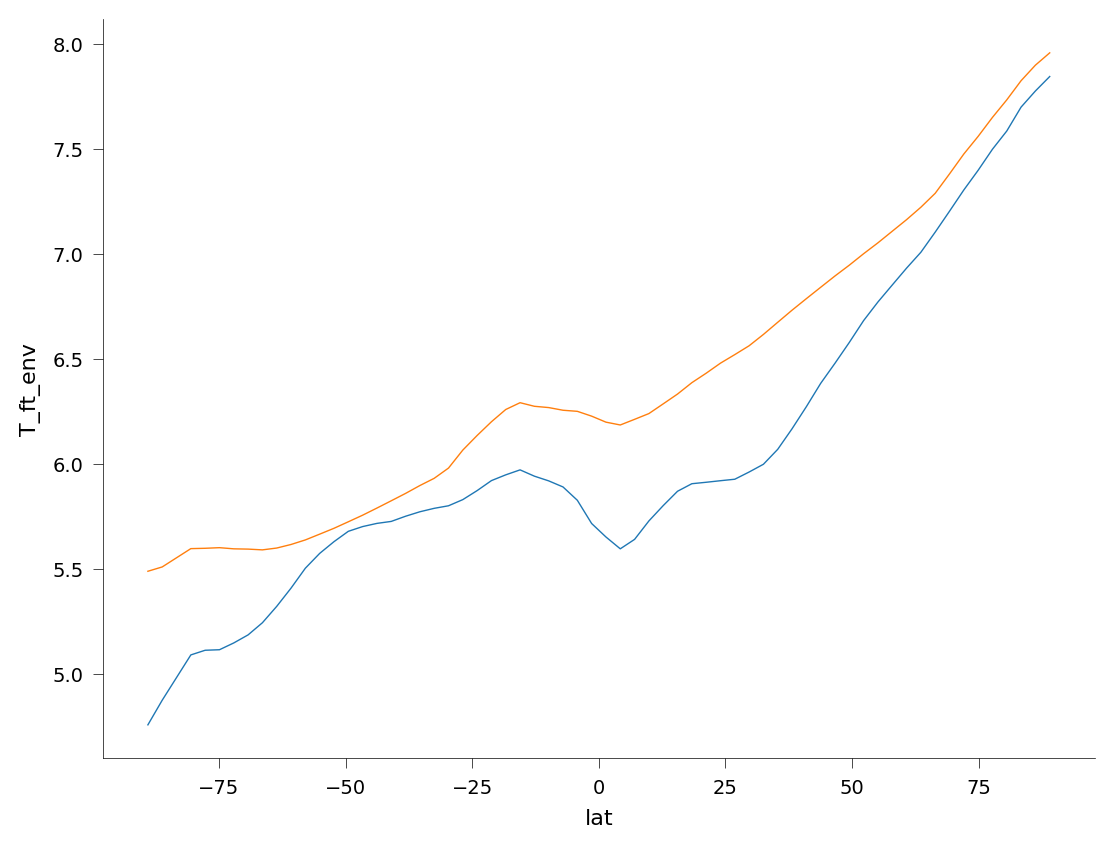

In [159]:
# get_var_av(ds_ref.isel(co2=0), mask=mask_loc).TREFHT.plot()
(get_var_av(ds_ref.isel(co2=1), mask=mask_loc).TREFHT - get_var_av(ds_ref.isel(co2=0), mask=mask_loc).TREFHT).plot()
(get_var_av(ds_ref.isel(co2=1), mask=mask_loc).T_ft_env - get_var_av(ds_ref.isel(co2=0), mask=mask_loc).T_ft_env).plot()

In [ ]:
ds_ref = ds.where(lsm).mean(dim='sample')
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(co2=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(co2=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

In [ ]:
ds_ref = ds2.mean(dim='sample')

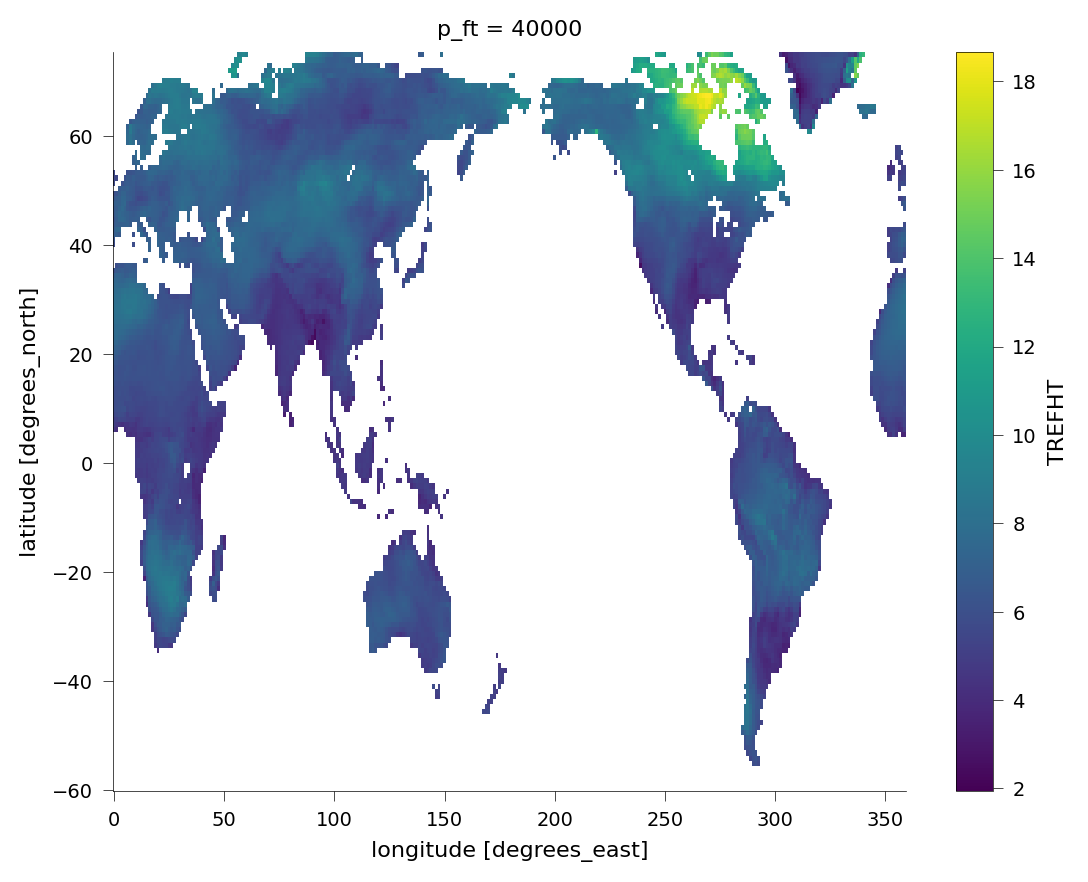

In [87]:
ds.TREFHT.mean(dim='sample').diff(dim='co2').squeeze().where(lsm).plot()

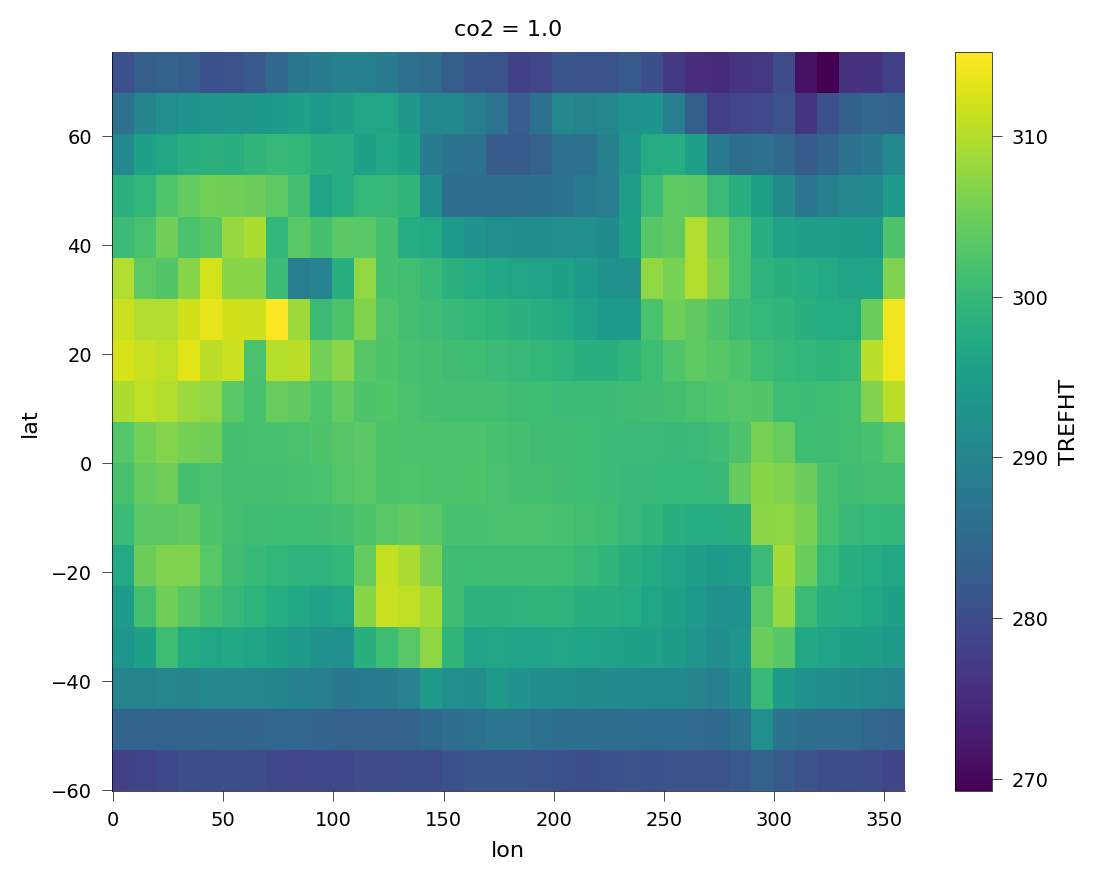

In [150]:
ds_coarse.TREFHT.isel(co2=0).mean(dim='sample').plot()

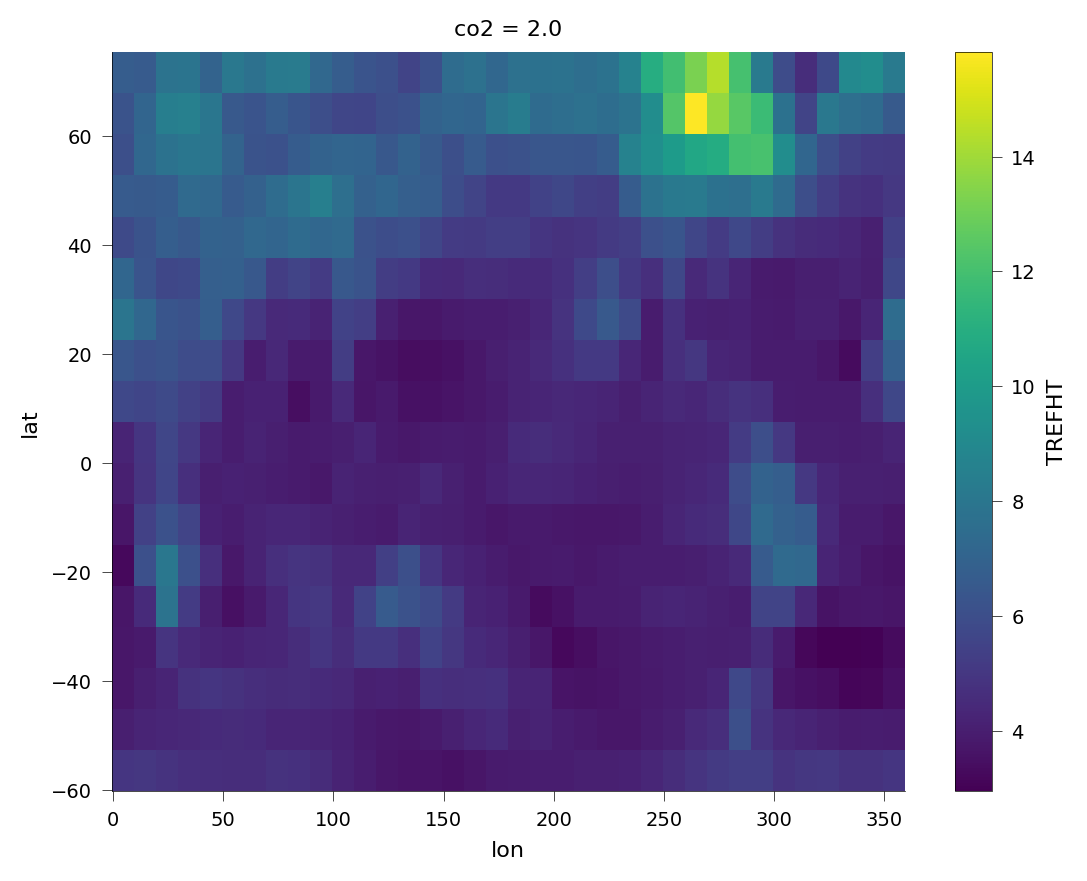

In [147]:
ds_coarse.TREFHT.mean(dim='sample').diff(dim='co2').squeeze().plot()

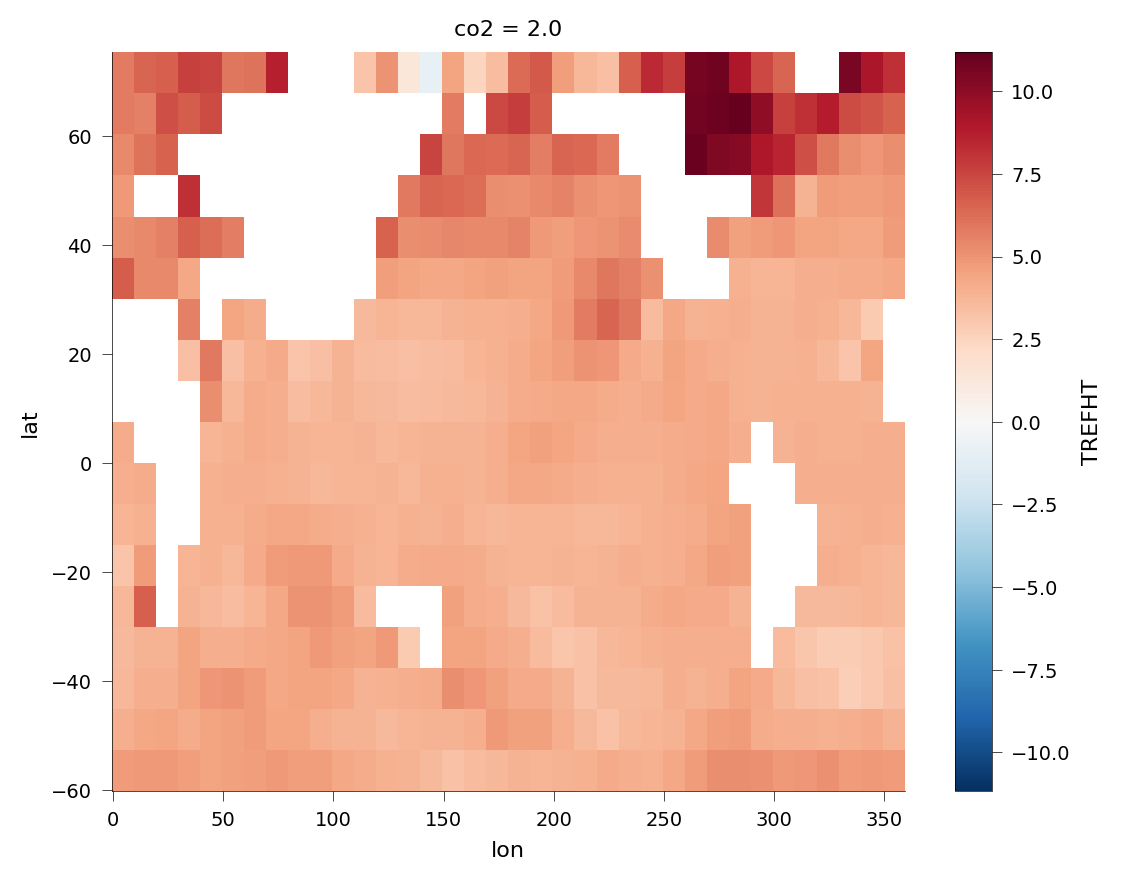

In [140]:
# Only show regions where atleast 25% are convective
ds_coarse.TREFHT.where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').squeeze().plot()

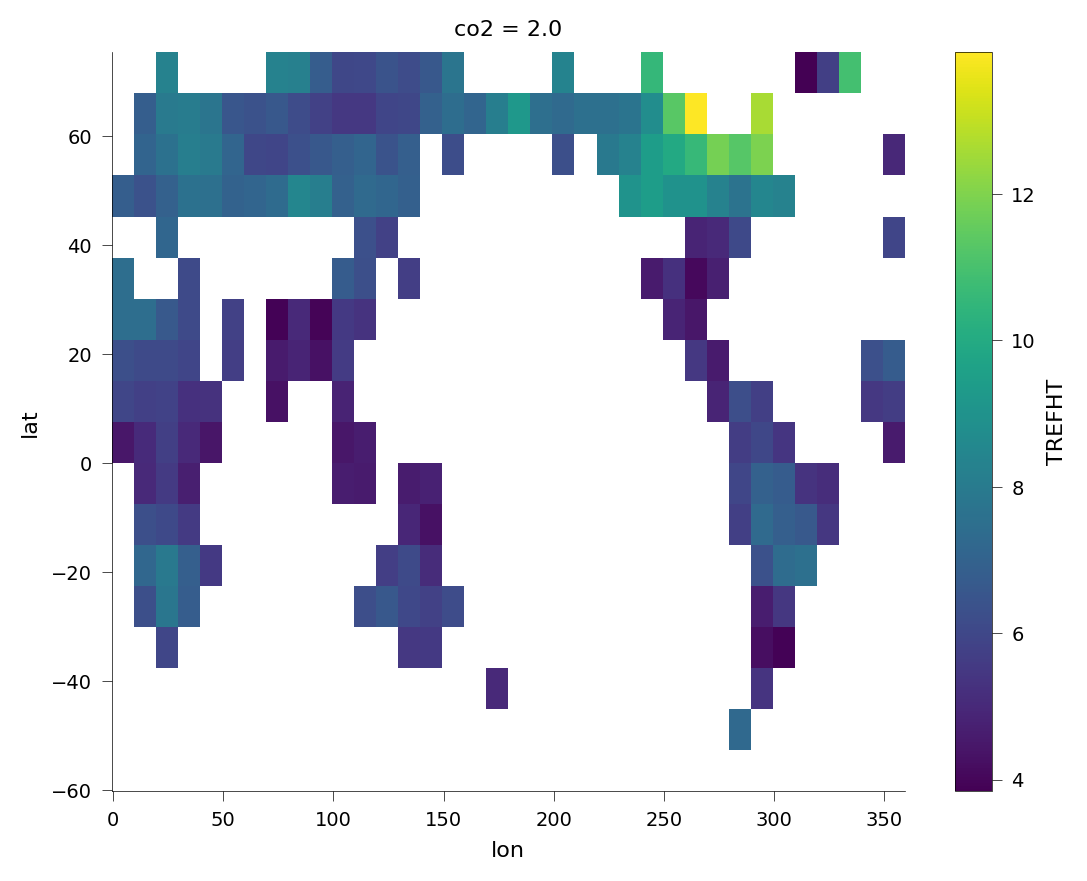

In [78]:
ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()

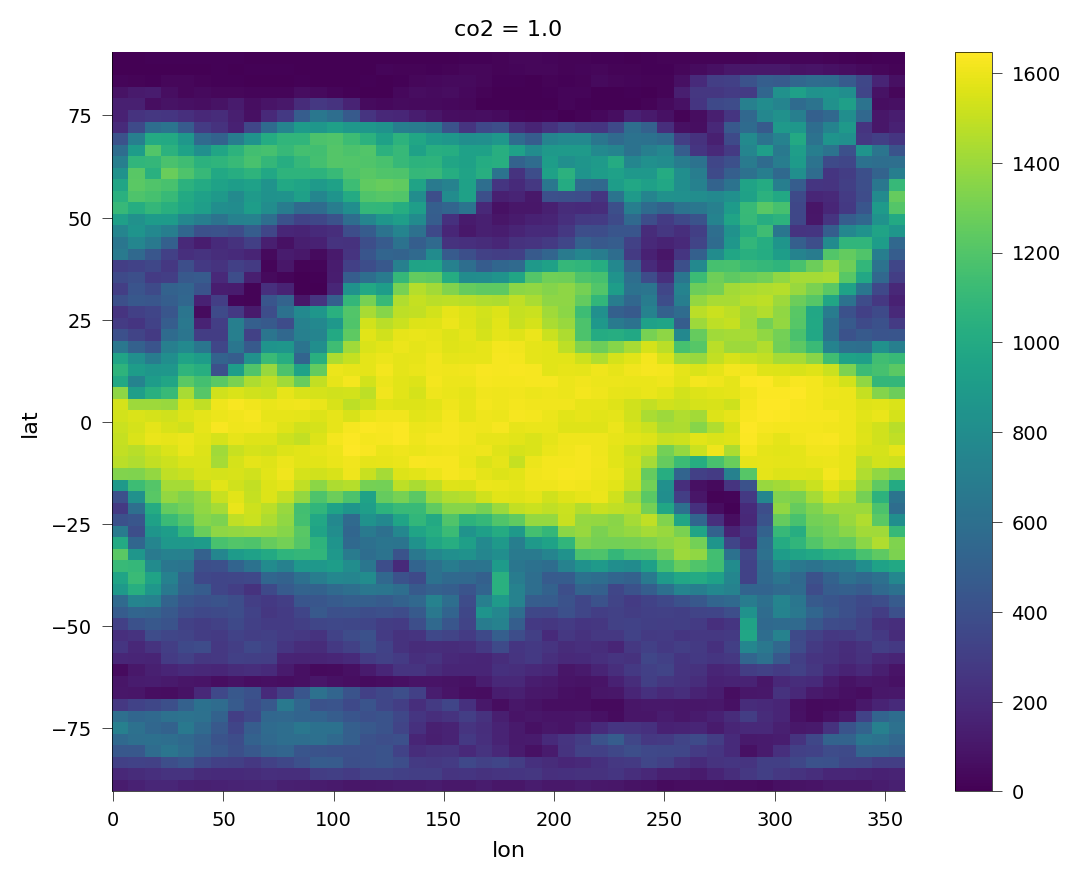

In [13]:
utils.get_valid_mask(ds2).sum(dim='sample').isel(co2=0).plot()

In [16]:
ds2.lon

<xarray.DataArray 'lon' (lon: 336)> Size: 3kB
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75])
Coordinates:
  * lon      (lon) float64 3kB 0.0 1.25 2.5 3.125 ... 355.6 356.2 357.5 358.8
    p_ft     int64 8B 40000

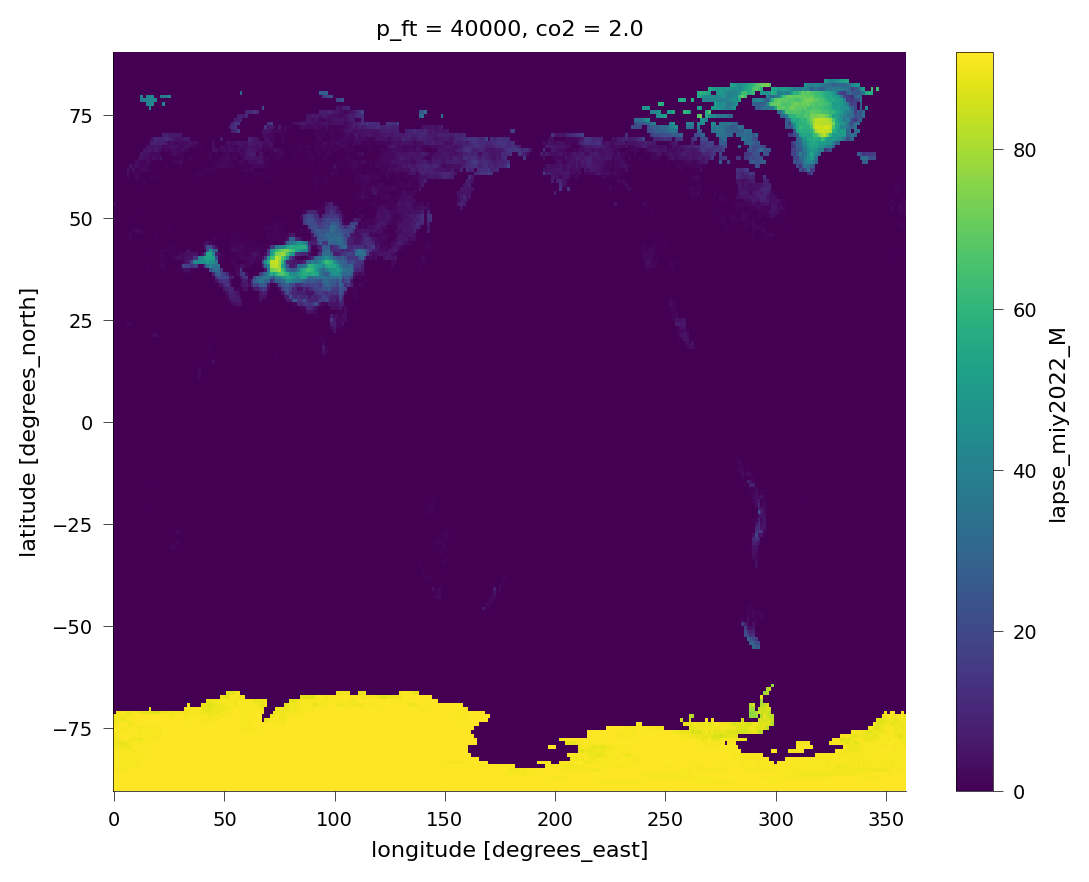

In [53]:
(ds.lapse_miy2022_M > 13).sum(dim='sample').isel(co2=1).plot()

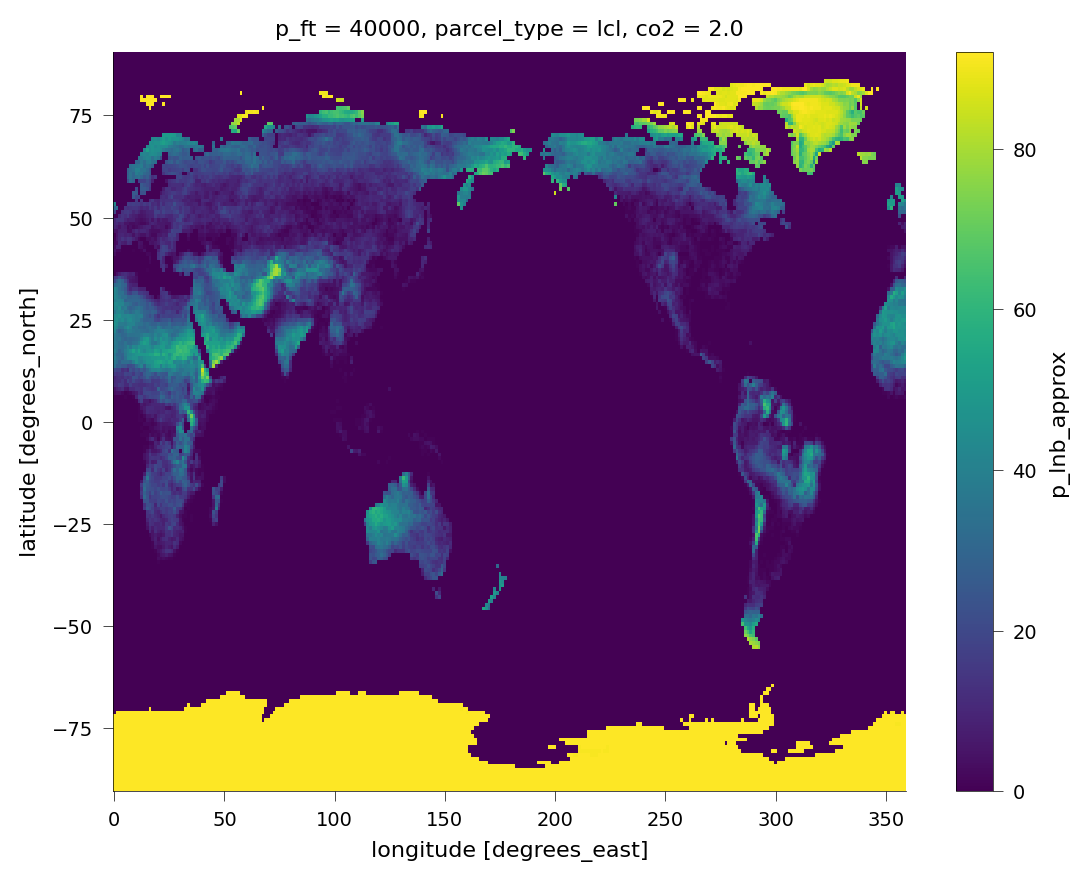

In [54]:
(ds.p_lnb_approx > p_ft).sum(dim='sample').isel(co2=1, parcel_type=1).plot()

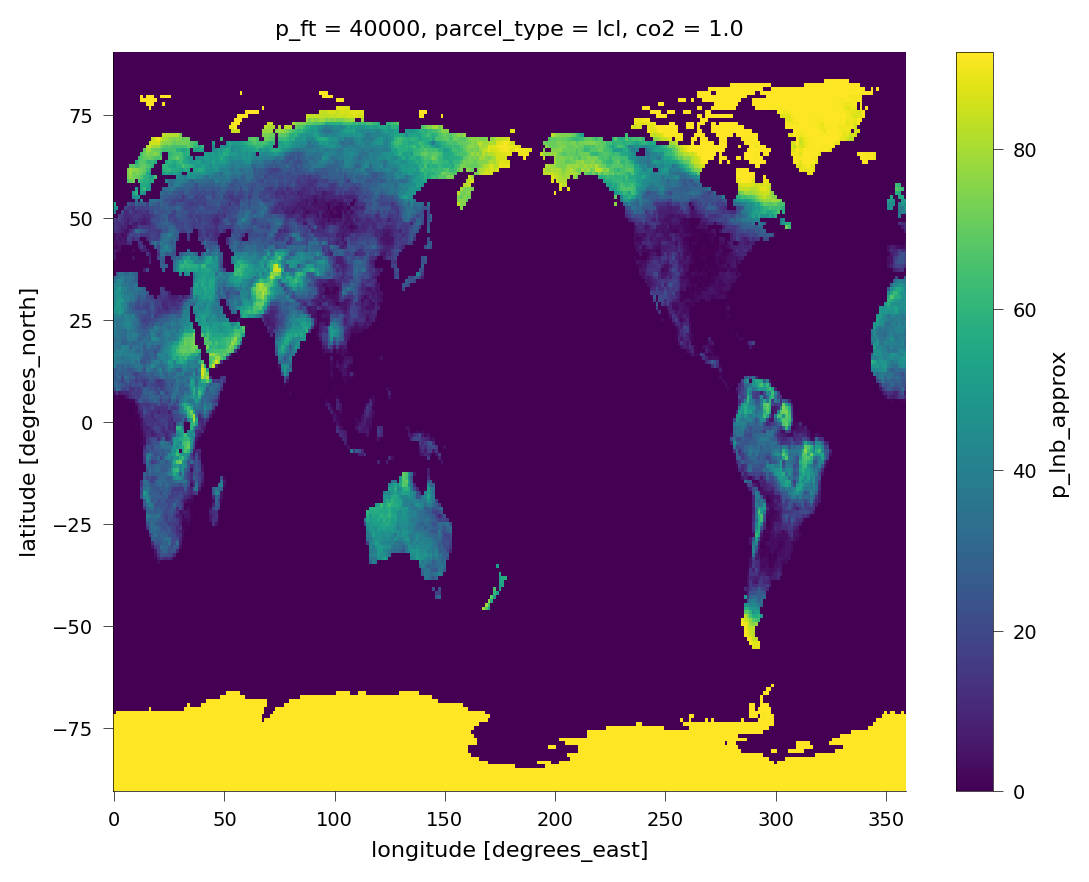

In [43]:
(ds.p_lnb_approx > p_ft).sum(dim='sample').isel(co2=0, parcel_type=1).plot()

In [5]:
def get_ds_quant_and_ref(ds):
    mask_fit = utils.get_valid_mask(ds)

    # Get rid of variables don't need anymore - those with layer dimension
    ds = ds.drop_dims(['layer', 'lev'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['lon_sample', 'quant'])  # reference average over all days, even not convective
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='lon_sample')
    ds_quant['n_conv_days'] = mask_fit.sum(dim='lon_sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M']].where(mask_fit).std(dim='lon_sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref, mask_fit
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant = [0, 0]
ds_ref = [0, 0]
mask_conv_valid = [0, 0]
for i, surf in enumerate(ds):
    ds_quant[i], ds_ref[i], mask_conv_valid[i] = get_ds_quant_and_ref(ds[surf])
ds_quant = xr.concat(ds_quant, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))
ds_ref = xr.concat(ds_ref, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))
mask_conv_valid = xr.concat(mask_conv_valid, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))

In [128]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(co2=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(co2=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_quant = ds_quant.transpose('surf', 'co2', 'quant', 'lat', 'parcel_type')
ds_ref = ds_ref.transpose('surf', 'co2', 'lat', 'parcel_type')

## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [44]:
ds_sf = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc=temp_surf_lcl_calc, sCAPE_form=False,
                                        numerical=False)
ds_sf_num = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc=temp_surf_lcl_calc,
                                            sCAPE_form=False, numerical=True)

In [46]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1
# Set numerical method to show difference to linear theory
for key in ds_sf:
    if 'scale_factor_sum' in key:
        continue
    ds_sf_num[key] = ds_sf_num[key] - ds_sf[key] + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework.

Weighting is slightly different in that not same amount of convective days at each latitude for each quant. So for each quant, preferentially weight latitudes with more convective days.

In [87]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", labels_cont['lapse_D_change']),
    "lapse_M_change": ("C1", "-", labels_cont['lapse_M_change']),
    "sCAPE_change": ("C1", ":", labels_cont['sCAPE_change']),
    "p_surf_change": ("C0", ":", labels_cont['p_surf_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", labels_cont['temp_surf_anom']),
    "rh_anom": ("C4", "-", labels_cont['rh_anom']),
    "p_surf_anom": ("C4", ":", labels_cont['p_surf_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory'),

    # non-linear
    "nl_temp_surf_anom_rh_change": ('C3', '-', '$\Delta T_s \delta r_s$'),
    "nl_rh_change_lapse_D_anom": ('C0', '-', '$\Delta \eta_D \delta r_s$'),
    "nl_temp_surf_anom_lapse_M_change": ('C1', '-', '$\Delta T_s \delta \eta_M$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$'),
    "nl_temp_ft_change_rh_anom": ('C2', '-', '$\Delta T_s \delta T_{FT}$'),
    "nl_temp_ft_change_p_surf_anom": ('C2', '-', '$\Delta p_s \delta T_{FT}$'),
    "nl_temp_surf_anom_rh_anom": ('C4', '-', '$\Delta T_s \Delta r_s$'),
    "nl_temp_surf_anom_p_surf_anom": ('C4', ':', '$\Delta T_s \Delta p_s$'),
    "nl_rh_change_rh_anom": ('C0', '-', '$\Delta r_s \delta r_s$'),
}

In [8]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
weights_use = ds_quant.n_conv_days.sum(dim='co2')
weights_use = weights_use * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use = weights_use / weights_use.max(dim='lat')

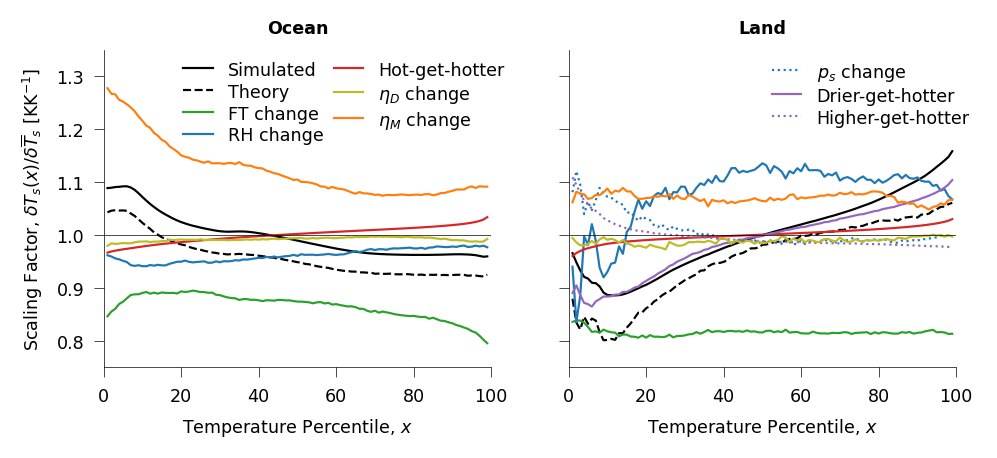

In [48]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
keys_added = []
for k in range(ds_sf.surf.size):
    ax[k].set_title(ds_sf.surf.values[k].capitalize(), fontweight='bold')
    for key in ['', '_sum']:
        var = ds_sf.isel(surf=k)[f"scale_factor{key}"].weighted(weights_use.isel(surf=k)).mean(dim='lat')
        #var = np.average(ds_sf.isel(surf=k)[f"scale_factor{key}"], axis=0, weights=lat_weights)
        ax[k].plot(ds_sf.quant, var,
                   color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
                   label=style_map[f"scale_factor{key}"][2] if k == 0 else None)
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[f"scale_factor_sum"], axis=0, weights=lat_weights),
    #         color=style_map[f"scale_factor_sum"][0],
    #         label='Theory (CAPE)', linestyle=':')
    # ax.plot(ds_sf_num.quant,
    #         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
    #         color='k', linestyle='--', label='Linear + nl_r_change')
    for key in ds_sf:
        if 'scale_factor' in key:
            continue
        if np.nanmax(np.average(np.abs(ds_sf.isel(surf=k)[key] - 1), axis=0, weights=lat_weights)) < 0.02:
            continue
        var = ds_sf.isel(surf=k)[key].weighted(ds_quant.isel(surf=k).n_conv_days.sum(dim='co2')).mean(dim='lat')
        # var = np.average(ds_sf.isel(surf=k)[key], axis=0, weights=lat_weights)
        ax[k].plot(ds_sf.quant, var,
                   label=None if key in keys_added else style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
        keys_added.append(key)
    # # sanity check that all other mechanisms are the same
    # if 'lapse' in key:
    #     continue
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[key], axis=0, weights=lat_weights), color=style_map[key][0],
    #            linestyle=':')
# ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape['sCAPE_change'], axis=0, weights=lat_weights),
#         color=style_map['sCAPE_change'][0], linestyle=':', label='CAPE change')

update_linewidth(fig)
ax[0].legend(ncol=2, handlelength=leg_handlelength, labelspacing=0.2, columnspacing=0.5, bbox_to_anchor=(1.08, 1.02),
             loc='upper right')

ax[1].legend(handlelength=leg_handlelength, labelspacing=0.2, bbox_to_anchor=(1.08, 1.02), loc='upper right')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(utils.percentile_label)
ax[1].set_xlabel(utils.percentile_label)
ax[0].set_ylabel(utils.sf_label)
update_fontsize(fig)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.75, 1.35)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

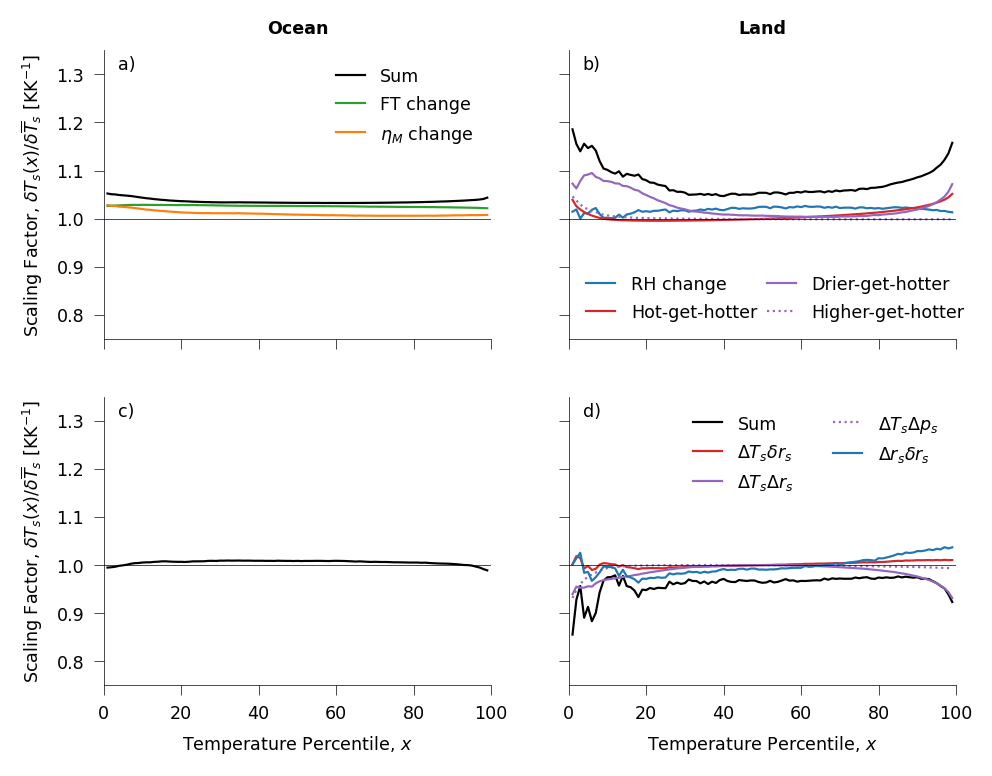

In [109]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k in range(ds_sf.surf.size):
    ax[0, k].set_title(ds_sf.surf.values[k].capitalize(), fontweight='bold')
    ax[1, k].set_xlabel(utils.percentile_label)
    # ax[0].set_title('Individual Mechanism Error', fontweight='bold')
    #ax[1].set_title('Mechanism Combination Error', fontweight='bold')
    ax[0, k].plot(ds_sf_num.quant,
                  (ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1).isel(surf=k).weighted(
                      weights_use.isel(surf=k)).mean(dim='lat'),
                  color='k', label='Sum' if k == 0 else None)

    ax[1, k].plot(ds_sf_num.quant, ds_sf_num['nl_sum'].isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat'),
                  color='k', linestyle='-', label='Sum')

    # Plot individual mechanism error
    for key in ds_sf:
        if 'scale_factor' in key:
            continue
        if np.nanmax(np.abs(ds_sf[key] - 1).isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat')) < 0.02:
            continue
        if np.nanmax(np.abs(ds_sf_num[key] - 1).isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat')) > 0.02:
            ax[0, k].plot(ds_sf.quant, ds_sf_num[key].isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat'),
                          label=style_map[key][2], color=style_map[key][0], linestyle=style_map[key][1])

    # Plot combination of mechanism error
    for key in ds_sf_num:
        if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('residual' in key):
            continue
        # Just plot 4 strongest mechanisms
        if np.nanmax(np.abs(ds_sf_num[key] - 1).isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat')) > 0.04:
            ax[1, k].plot(ds_sf.quant, ds_sf_num[key].isel(surf=k).weighted(weights_use.isel(surf=k)).mean(dim='lat'),
                          label=style_map[key][2],
                          color=style_map[key][0], linestyle=style_map[key][1])
#
update_linewidth(fig)
ax[0, 0].legend(handlelength=leg_handlelength)
ax[0, 1].legend(ncol=2, handlelength=leg_handlelength, columnspacing=0.5)
ax[1, 1].legend(ncol=2, handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-2)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)
ax[0, 0].set_ylabel(utils.sf_label)
ax[1, 0].set_ylabel(utils.sf_label)
update_fontsize(fig)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylim(0.75, 1.35)
plt.show()
# savefig(fig)

## Lapse rate values
Show values of the lapse rate parameters, and also include daily max data for comparison, and to comment about dry lapse rate.

Weighting is slightly different in that now in top row, we are plotting a value from a single climate hence use weighting from single climate `weights_use_sc`.

In [7]:
# For single climate, just use co2=0. weights_use was for scaling factor so combines co2 datasets
weights_use_sc = ds_quant.n_conv_days.isel(co2=0)
weights_use_sc = weights_use_sc * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use_sc = weights_use_sc / weights_use_sc.max(dim='lat')

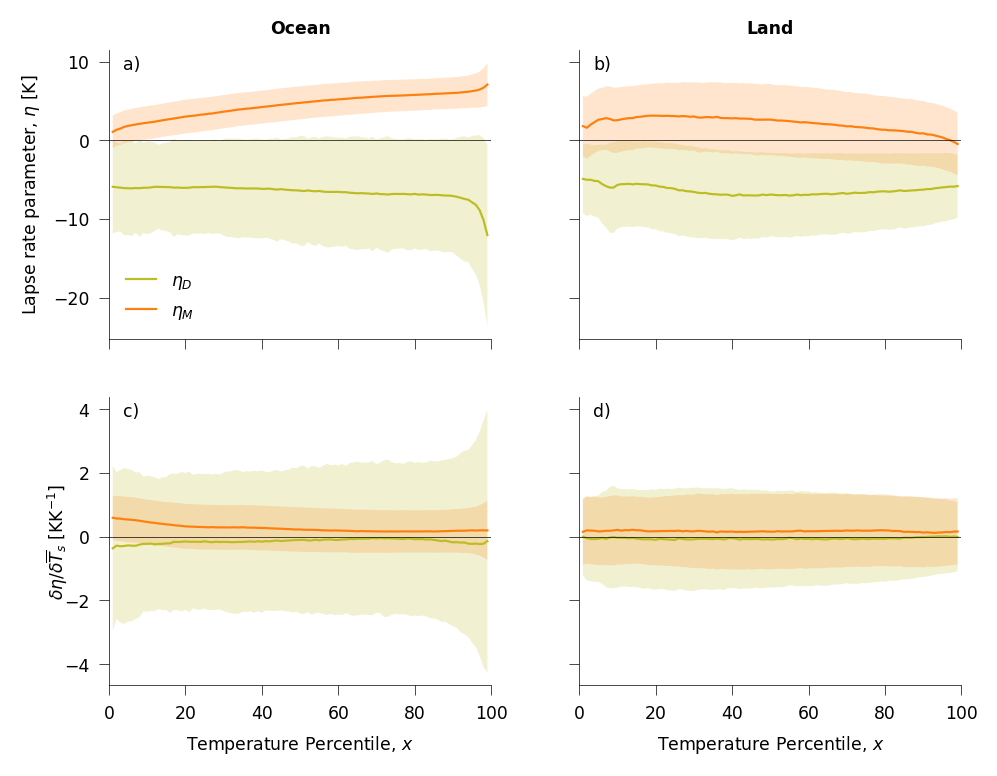

In [126]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
fig_resize(fig, width['two_col'])
for j in range(ds_sf.surf.size):
    ax[0, j].set_title(ds_sf.surf.values[j].capitalize(), fontweight='bold')
    ax[1, j].set_xlabel(utils.percentile_label)
    for i, key in enumerate(['lapse_D', 'lapse_M']):
        ax[0, j].plot(ds_sf.quant,
                      ds_quant[key].isel(co2=0, surf=j).weighted(weights_use_sc.isel(surf=j)).mean(dim='lat'),
                      color=style_map[f'{key}_change'][0], label=['$\eta_D$', '$\eta_M$'][i])
        ax[0, j].fill_between(ds_sf.quant,
                              (ds_quant[key] - ds_quant[f"{key}_std"]).isel(co2=0, surf=j).weighted(
                                  weights_use_sc.isel(surf=j)).mean(dim='lat'),
                              (ds_quant[key] + ds_quant[f"{key}_std"]).isel(co2=0, surf=j).weighted(
                                  weights_use_sc.isel(surf=j)).mean(dim='lat'),
                              alpha=0.2,
                              color=style_map[f'{key}_change'][0], edgecolor="none")
        var = ds_quant[key].diff(dim='co2').squeeze() / ds_ref.TREFHT.diff(dim='co2').squeeze()
        var = var.isel(surf=j)
        ax[1, j].plot(ds_sf.quant, var.weighted(weights_use.isel(surf=j)).mean(dim='lat'),
                      color=style_map[f'{key}_change'][0],
                      label='Daily average' if i == 0 else None)
        std_diff = np.sqrt(ds_quant[f"{key}_std"].isel(co2=0) ** 2 + ds_quant[f"{key}_std"].isel(co2=1) ** 2
                           ) / ds_ref.TREFHT.diff(dim='co2').squeeze()
        std_diff = std_diff.isel(surf=j)
        ax[1, j].fill_between(ds_sf.quant,
                              (var - std_diff).weighted(weights_use.isel(surf=j)).mean(dim='lat'),
                              (var + std_diff).weighted(weights_use.isel(surf=j)).mean(dim='lat'),
                              alpha=0.2,
                              color=style_map[f'{key}_change'][0], edgecolor="none")

    # ax[0].plot(ds_sf.quant, np.average(ds_quant_daily_max[key].isel(co2=0), axis=1, weights=lat_weights),
    #            color=style_map[f'{key}_change'][0], linestyle='--')
    # ax[1].plot(ds_sf.quant, np.average(
    #     ds_quant_daily_max[key].diff(dim='tau_lw').squeeze() / ds_ref_daily_max.TREFHT.diff(dim='tau_lw').squeeze(),
    #     axis=1, weights=lat_weights),
    #            color=style_map[f'{key}_change'][0], linestyle='--', label='Daily max' if i == 0 else None)
update_linewidth(fig)
ax[0, 0].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-2)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
update_fontsize(fig)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylabel('Lapse rate parameter, $\eta$ [K]')
ax[1, 0].set_ylabel('$\delta \eta/ \delta \overline{T}_s$ [KK$^{-1}$]', labelpad=-2)
fig.subplots_adjust(wspace=0.23)
update_fontsize(fig)
plt.show()
# savefig(fig)

## LNB Analysis
Idea is to show that cold day amplified warming is due to more days having LNB further from surface than 500hPa

The LNB and Miyawaki 2022 plots do not coincide - maybe no regime change.

The $\eta_M$ change mechanism and change in number of days LNB further from surface than FT level seem well correlated again. With warming, convection reaching higher in atmosphere.

Can also comment on using 700hPa instead of 500hPa - say error a lot higher, and see similar change in % of days p_LNB<p_ft when using p_ft=700hPa

NOTE - This is the % of convective days which satisfy a condition.

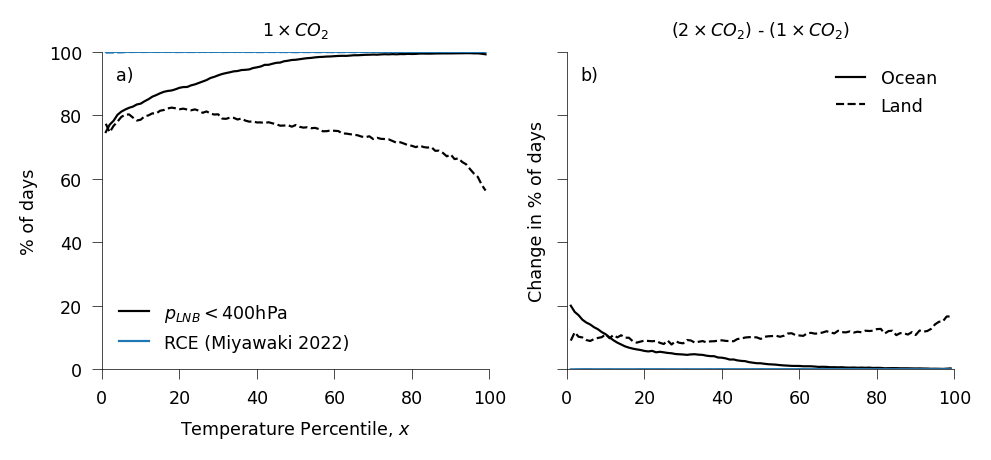

In [13]:
lapse_miy2022_M_thresh = 13  # 13% threshold value for RCE comes from paper
lnb_buoyancy_method = 'lcl'  # think lcl is better - better estimate of height convection can possibly reach
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# surf = 'ocean'
# n_sample = (ds[surf].TREFHT > 0).sum(dim='lon_sample')
for k, surf in enumerate(mask_conv_valid.surf.values.tolist()):
    # for i in range(ds.tau_lw.size):
    #     # ax[0].plot(ds_sf.quant, np.average(ds_quant['p_lnb_approx'].isel(tau_lw=i), axis=1, weights=lat_weights), color=f"C{i}")
    # var = (ds[surf][key] < p_ft).sum(dim='lon_sample') / n_sample
    n_sample = mask_conv_valid.isel(surf=k).sum(dim='lon_sample')  # total number of convective days at each location
    var = (ds[surf].p_lnb_approx.where(mask_conv_valid.isel(surf=k)) < p_ft).sum(dim='lon_sample') / n_sample
    var = var.sel(parcel_type=lnb_buoyancy_method)
    ax[0].plot(ds[surf].quant, var.isel(co2=0).weighted(weights_use_sc.isel(surf=k)).mean(dim='lat') * 100, color=f"k",
               linestyle=[None, '--'][k], label='$p_{LNB} < ' + f'{p_ft / 100:.0f}$hPa' if k == 0 else None)
    ax[1].plot(ds[surf].quant, var.diff(dim='co2').squeeze().weighted(weights_use.isel(surf=k)).mean(dim='lat') * 100,
               color=f"k",
               linestyle=[None, '--'][k], label=surf.capitalize())
    # Plot 700hPa values - rather than just
    # var = (ds[key]<ds700.p_ft).sum(dim='sample')/ds.sample.size
    # ax[0].plot(ds.quant, np.average(var.isel(tau_lw=0), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
    # ax[1].plot(ds.quant, np.average(var.diff(dim='tau_lw').squeeze(), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
    var = (ds[surf].lapse_miy2022_M < lapse_miy2022_M_thresh).where(mask_conv_valid.isel(surf=k)).sum(
        dim='lon_sample') / n_sample
    ax[0].plot(ds[surf].quant, var.isel(co2=0).weighted(weights_use_sc.isel(surf=k)).mean(dim='lat') * 100, color=f"C0",
               label='RCE (Miyawaki 2022)' if k == 0 else None, linestyle=[None, '--'][k])
    ax[1].plot(ds[surf].quant, var.diff(dim='co2').squeeze().weighted(weights_use.isel(surf=k)).mean(dim='lat') * 100,
               color=f"C0")
update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days')
ax[0].set_xlabel(utils.percentile_label)
ax[0].set_title(utils.co2_labels[0])
ax[1].set_title(f'({utils.co2_labels[1]}) - ({utils.co2_labels[0]})')
label_subplots(fig, ax, box_alpha=0)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Miyawaki analysis

In [174]:
# surf = 'ocean'
# area_weighting(ds[surf].lapse_miy2022_M.mean(dim='lon_sample')).mean(dim='lat').isel(co2=0).plot()

In [175]:
# area_weighting(ds_quant.lapse_miy2022_M).mean(dim='lat').isel(co2=0).plot()
# area_weighting(-ds_quant.lapse_miy2022_M).mean(dim='lat').diff(dim='co2').squeeze().plot()